# Functions and dataframes. Please run these cells first.

### Load the dataframe (df), a list of parent sequence names (parent_seq_ids), and a dictionary with their respective wild-type sequences (parents_dict)

In [1]:
import pandas as pd
from Bio import SeqIO

# Open Data_S2 as df. Data_S2 contains all of the daughter sequences and their respective fluorescence scores.
df = pd.read_csv('Data_S2.csv')

# label_counts counts the number of daughter sequences for each parent
label_counts = df['matched_pi'].value_counts()

# convert label_counts to a dictionary
label_counts_dict = label_counts.to_dict()

# parent_seq_ids is a list of the possible parent sequences
parent_seq_ids = label_counts.index.unique().tolist()
#print(parent_seq_ids)

### Create a dictionary for the parents and their sequences
parents_dict = {}
for ID in parent_seq_ids:
    for record in SeqIO.parse('Parents.fasta', 'fasta'):
        if ID == str(record.id):
            parents_dict[ID] = str(record.seq)

# Display Data_S2 (df):
df.head()

,seq,sum_alpha,sum_beta,sum_gamma,sum_bin1,sum_bin2,sum_bin3,sum_bin4,sum_bin5,sum_bin6,...,distance,GFP_mean,GFP_std,GFP_median,RFP_mean,RFP_std,RFP_median,daughter_count,GFP_binary,RFP_binary
0,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,14,28,9,36,0,0,0,15,0,...,3,1.000000,0.000000,1.0,1.0,0.0,1.0,20061,1.000000,1.0
1,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,34,72,29,88,0,0,1,46,0,...,4,1.033708,0.316208,1.0,1.0,0.0,1.0,20061,1.033708,1.0
2,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,12,29,5,32,0,0,0,14,0,...,2,1.000000,0.000000,1.0,1.0,0.0,1.0,20061,1.000000,1.0
3,AAAAAATAATTTCATGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,8,24,5,22,0,0,0,15,0,...,3,1.000000,0.000000,1.0,1.0,0.0,1.0,20061,1.000000,1.0
4,AAAAAATAATTTCTCGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,33,14,9,27,0,0,0,29,0,...,2,1.000000,0.000000,1.0,1.0,0.0,1.0,20061,1.000000,1.0


### Split the dataframe into 3 sub_dfs for the mutual information analysis

In [2]:
# Calculate the number of rows in the DataFrame
df_length = len(df)

# Calculate the number of rows to be in each of the three DataFrames
split_size = df_length // 3

# Shuffle the DataFrame for randomness
df = df.sample(frac=1, random_state=42)  # Use random_state for reproducibility

# Split the DataFrame into three random DataFrames
df1 = df.sample(n=split_size)
df = df.drop(df1.index)

df2 = df.sample(n=split_size)
df = df.drop(df2.index)

df3 = df  # The remaining rows go into the third DataFrame

# Reset the index of the new DataFrames
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)

triplicates = [df1, df2, df3]

# Read the Data_S2.csv file
df = pd.read_csv('Data_S2.csv')

### Load the sigma70 PWMs

In [3]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio import motifs
import math
import numpy as np

PSSM_txt_open = open('sigma70.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

# Create dictionaries to store this information
PSSMs_dict = {}
threshold_dict = {}
list_of_TFs = []

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
print("PSSMs and thresholds calculated!")

PSSMs and thresholds calculated!


### def WT_pwms(Fluor, window_size, ID, scrambled)

In [4]:
def WT_pwms(Fluor, window_size, ID, scrambled):
    
    list_of_TFs = ['minus10', 'minus35']
    
    import random
    dictionary_10_35 = {}
    
    # Look only at the parent sequence
    sequence = parents_dict[ID]

    # Scramble it if scrambled is true
    if scrambled == True:
        random.seed(23)
        dna_bases = 'ATCG'
        sequence = ''.join(random.choice(dna_bases) for _ in sequence)
    
    # Flip seqeunce if mScarlet
    if Fluor == 'RFP':
        sequence = Seq(sequence)
        sequence = sequence.reverse_complement()
    
    for TF in list_of_TFs:
        window_list = []
        # Loop through the sliding window
        for window_start in range(149):
            window = [window_start, window_size+window_start]
            if window[1] <= 150:

                # Crop the sequence to the window
                crop_sequence = sequence[window[0]:window[1]]

                # Calculate the PWM score
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(crop_sequence):

                    # Only looking on the top strand
                    if position>=0:
                        if score >= threshold_dict[TF]:
                            initial_score = score
                            #print(window)

                            window_list.append(window)

        # Initialize a list of 150 "0's"
        TF_plot = [0] * 150

        # Fill the positions within the specified ranges with "1"
        for start, end in window_list:
            for i in range(start, end):
                TF_plot[i] = 1

        #print(TF_plot)
        sns.lineplot(x=range(0,150), y=TF_plot)
        plt.gca().set_aspect(10)
        
        dictionary_10_35[TF] = TF_plot
        
    return dictionary_10_35

### def calculate_mutual_information(ID, Fluor, blur)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from scipy.ndimage import gaussian_filter

# ID = parent sequence, fluor = GFP or RFP, blur = sigma parameter
def calculate_mutual_information(ID, Fluor, blur):
    
    # Calculates the mutual information for all three replicates and add to a dictionary
    replicate_ID_dict = {}
    for x, df in enumerate(triplicates):

        # Sort the dataframe
        ID_df = df[df['matched_pi'].apply(lambda x: x == ID)] # Only show dataframe for this particular sequence
        sequences = ID_df['seq'].to_list()
        
        if Fluor == 'RFP':
            sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

        # GFP or mScarlet?
        if Fluor == 'GFP':
            scores = ID_df['GFP_median'].to_list()
        elif Fluor == 'RFP':
            scores = ID_df['RFP_median'].to_list()
        rounded_scores = [np.round_(x) for x in scores]

        j_bases = ['A','T','C','G']
        f_bins = [1,2,3,4]

        i_bits = []
        # Build each column proceduraly
        for i in range(150):
            column_i = []
            n_scores = []
            for n in range(len(sequences)):    
                Sequence = sequences[n]
                column_i.append(Sequence[i])
                n_scores.append(rounded_scores[n])

            ### The column is now built. Go procedurally through each base and bin to sum together the Bit
            Correction = (9*np.log2(math.e)/(2*(len(column_i)))) # This is for subtracting after each iteration. Independent of position. Calculate once.

            Bit = 0
            for j, f in itertools.product(j_bases, f_bins):
                pibj = column_i.count(j)/len(column_i) # Pi(bj) <-- probability of base j occuring at position i
                pif = n_scores.count(f)/len(n_scores) # Pi(f) <-- probability of a score f occuring at position i

                # Calculate pibjf. First create a list of all 
                index_list = [index for index, e in enumerate(n_scores) if e == f] # return a list of indexes where the score is f in the n_scores list
                j_count = 0
                for index in index_list: # Use this index list to go through column_i to if find all instances where base j occurs (j_count)
                    if column_i[index] == j:
                        j_count = j_count+1
                pibjf = j_count / len(column_i) # j_count is the number of times base j occurs with fluorescence score f. Divide by column length to get Pi(bj, f)

                # Calculate the fraction: Pi(bj,f) / (Pi(bj))*(Pi(f))        
                if pibj*pif == 0:
                    fraction =0

                else:
                    fraction = pibjf / (pibj*pif)

                if fraction == 0: # You cannot take the log of 0
                    pass
                else:

                    # Calculate and sum the Bit value together
                     Bit = Bit + pibjf*(np.log2(fraction))

            # Append the Bit at position i to the i_bits list
            i_bits.append(Bit-Correction)

        replicate_ID_dict[x] = gaussian_filter(i_bits, sigma=blur) # With gaussian blur

    # Calculate the average mutual information and the standard deviation
    
    ID_mean_mutual_information = []
    ID_std_mutual_information = []
    
    for i in range(150):
        i_values = []
        for x in range(3):
            i_values.append(replicate_ID_dict[x][i])
            
        ID_mean_mutual_information.append(np.mean(i_values))
        ID_std_mutual_information.append(np.std(i_values))
    
    # rename for simplicity
    means = ID_mean_mutual_information
    std_devs = ID_std_mutual_information
    
    return(means, std_devs)

### def find_peaks(values, p)

In [6]:
def find_peaks(values, p):
    peaks = []
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            
            # If greater than the percentile threshold
            if values[i] >= p:
            
                peaks.append(i)
    return peaks

### def index_hotspots(means, std_devs)

In [7]:
# Returns the indexes for hotspots
def index_hotspots(means, std_devs):
    
    # Create a list with the standard deviation subtracted from the mean for each position.   
    means = np.array(means)
    std_devs = np.array(std_devs)
    mean_minus_std = means-std_devs
    
    # Calculate a threshold percentile
    p = np.percentile(mean_minus_std, 90)
    
    ## A minimum threshold - sets all values less than it equal to 0
    min_threshold = 0.0005
    mean_minus_std[mean_minus_std < min_threshold] = 0
        
    
    if p <= 0:
        peak_indices = []       
    else:
        # Return indices for peaks
        peak_indices = find_peaks(mean_minus_std, p)

    # Return a list of hotspot sequences
    return peak_indices

### def count_motifs(orientation, TF, window_size, ID)

In [8]:
def count_motifs(orientation, TF, window_size, ID):

    # Look only at the parent sequence
    sequence = parents_dict[ID]        

    # Flip seqeunce if mScarlet
    if orientation == 'bottom':
        sequence = Seq(sequence)
        sequence = sequence.reverse_complement()

    window_list = []
    # Loop through the sliding window
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:

            # Crop the sequence to the window
            crop_sequence = sequence[window[0]:window[1]]

            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):

                # Only looking on the top strand
                if position>=0:
                    if score >= threshold_dict[TF]:
                        initial_score = score
                        #print(window)

                        window_list.append(window)

    # Initialize a list of 150 "0's"
    TF_plot = [0] * 150

    # Fill the positions within the specified ranges with "1"
    for start, end in window_list:
        for i in range(start, end):
            TF_plot[i] = 1

    return(TF_plot)

### def mann_whitney_u_test(data1, data2)

In [9]:
from scipy.stats import mannwhitneyu

def mann_whitney_u_test(data1, data2):

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(data1, data2)

    return u_statistic, p_value

### def PWM_fluorescence_slide_function(orientation, filename, Fluor, TF, window_size)

In [10]:
def PWM_fluorescence_slide_function(orientation, filename, Fluor, TF, window_size):
    
    output_rows = []
    
    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.matched_pi != filename)].index)
    
    # Drop rows with 'nan' values
    sub_df = sub_df.dropna()
    
    # Update the window_size if it needs to be different from 6
    if TF == 'minus10' or TF == 'minus35':
        window_size = 6
        
    elif TF == 'HNS':
        window_size = 12
    
    elif TF == 'UP':
        window_size = 22
    
    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = sub_df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        fluorescence_scores = sub_df['RFP_mean'].to_list()

    # Get the daughter seqeunces
    sequences = sub_df['seq'].to_list()
    
    # Take the reverse complement if orientation == 'bottom':
    if orientation == 'bottom':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

    # Loop through the sliding window
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:

            TF_scores = []
            # Loop through each sequence
            for sequence in sequences:

                # Crop the sequence to the window
                crop_sequence = sequence[window[0]:window[1]]

                # Calculate the PWM score
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(crop_sequence):

                    # Only looking on the top strand
                    if position>=0:
                        initial_score = score

                # Append to a list
                TF_scores.append(initial_score)

            ### Violin plots between PWM scores below vs above the threshold and fluorescence
            below_fluorescences = []
            above_fluorescences = []

            for n in range(len(TF_scores)):
                if TF_scores[n] < threshold_dict[TF]:
                    below_fluorescences.append(fluorescence_scores[n])
                else:
                    above_fluorescences.append(fluorescence_scores[n])
                    
            # Calculate the KS test
            if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:
                
                # See if there is a noticable difference between them first
                median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                
                # MWU test
                u_statistic, p_value = mann_whitney_u_test(below_fluorescences, above_fluorescences)
                
                
                output_list = [p_value, window, len(below_fluorescences), len(above_fluorescences),
                               np.median(below_fluorescences), np.median(above_fluorescences)]
                
                output_rows.append(output_list)
                        
    return output_rows

### def wild_type_boxes(Fluor, window_size, sequence)

In [11]:
def wild_type_boxes(Fluor, window_size, sequence):

    dictionary_10_35 = {}
    
    list_of_TFs = ['minus10', 'minus35']
    
    # Flip seqeunce if mScarlet
    if Fluor == 'RFP':
        sequence = Seq(sequence)
        sequence = sequence.reverse_complement()
    
    for TF in list_of_TFs:
        window_list = []
        # Loop through the sliding window
        for window_start in range(149):
            window = [window_start, window_size+window_start]
            if window[1] <= 150:

                # Crop the sequence to the window
                crop_sequence = sequence[window[0]:window[1]]

                # Calculate the PWM score
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(crop_sequence):

                    # Only looking on the top strand
                    if position>=0:
                        if score >= threshold_dict[TF]:
                            initial_score = score

                            # Tag the beginning instance where the motif begins...
                            window_list.append(window_start)
        
        dictionary_10_35[TF] = window_list
        #print(TF_plot)
        
    return dictionary_10_35

### def individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

In [107]:
import random

def individual_gain_loss_pwm(orientation, ID, Fluor, TF, window):
    
    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.matched_pi != ID)].index)

    # Drop rows with 'nan' values
    sub_df = sub_df.dropna()

    # Update the window_size if it needs to be different from 6
    if TF == 'minus10' or TF == 'minus35':
        window_size = 6
        
    elif TF == 'HNS':
        window_size = 12

    elif TF == 'UP':
        window_size = 22

    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = sub_df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        fluorescence_scores = sub_df['RFP_mean'].to_list()

    # Get the seqeunces
    sequences = sub_df['seq'].to_list()
    #print(sequences[0])

    # Take the reverse complement if orientation == 'bottom':
    if orientation == 'bottom':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

    # Crop the sequences
    crop_sequences = []
    for sequence in sequences:
        crop_sequences.append(sequence[window[0]:window[1]]) # Look exclusively in the provided window

    TF_scores = []    
    for crop_sequence in crop_sequences:
        
        # Calculate the PWM score
        initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
        for position, score in PSSMs_dict[TF].search(crop_sequence):

            # Only looking on the top strand
            if position>=0:
                initial_score = score

        # Append to a list
        TF_scores.append(initial_score)

    ### Violin plots between PWM scores below vs above the threshold and fluorescence
    below_fluorescences = []
    above_fluorescences = []
    
    below_sequences = [] # These lists contain the cropped sequences to build consensuses or motifs
    above_sequences = [] # These lists contain the cropped sequences to build consensuses or motifs
    
    for n in range(len(TF_scores)):
        if TF_scores[n] < threshold_dict[TF]:
            below_fluorescences.append(fluorescence_scores[n])
            below_sequences.append(crop_sequences[n])
        else:
            above_fluorescences.append(fluorescence_scores[n])
            above_sequences.append(crop_sequences[n])

    # Calculate the KS test
    if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

        # See if there is a noticable difference between them first
        median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
        print(median_differences)

        # MWU test
        u_statistic, p_value = mann_whitney_u_test(below_fluorescences, above_fluorescences)

     # Plot the result...
    all_data = [below_fluorescences, above_fluorescences]

    # Create a boxplot
    sns.violinplot(data = all_data)
    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

    # Set the y-axis range
    plt.ylim(0.5, 4.5)

    # Add labels to the x-axis for each boxplot
    plt.xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
        
        
    # Print the instances
    print(len(below_sequences))
    print(len(above_sequences))
    
    below_m = motifs.create(below_sequences)
    above_m = motifs.create(above_sequences)
    
    print(below_m.degenerate_consensus)
    print(above_m.degenerate_consensus)
    
    # Print the scores
    initial_score = 0
    for position, score in PSSMs_dict[TF].search(below_m.degenerate_consensus):
        if position>=0:
            initial_score = score
    print(initial_score)
    
    initial_score = 0
    for position, score in PSSMs_dict[TF].search(above_m.degenerate_consensus):
        if position>=0:
            initial_score = score
    print(initial_score)

### def gained_motifs_count(ID, Fluor)

In [13]:
from sklearn import linear_model
import os
import re
import pickle
import copy
import numpy as np
import pandas as pd
import itertools
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate 
from sklearn.metrics import mean_squared_error,r2_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

def gained_motifs_count(ID, Fluor):
    list_of_TFs = ['minus10', 'minus35']

    #print("Looking for all possible -10 and -35 motif locations...")
    ### Look for all possible -10 and -35 motif locations.
    
    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.matched_pi != ID)].index)
    # Drop rows with 'nan' values
    sub_df = sub_df.dropna()

    # Get all possible -10 positions in the daughter sequences:
    all_10_coordinates = []
    all_35_coordinates = []

    for TF in list_of_TFs:
        #print(f'Motif: {TF}')

        for i, row in sub_df.iterrows():

            # For each daughter sequence
            daughter = row['seq']
            if Fluor == 'RFP':
                daughter = str(Seq(row['seq']).reverse_complement())             
    
            # Calculate PWMs
            output = WT_pwms('GFP', 6, daughter)

            if TF == 'minus10':   
                daughter_10_coordinates = output['minus10']

                # Add 10 coordinates to the master list
                all_10_coordinates += daughter_10_coordinates

                # Use "set" to get all the unique values (keeps all_10_coordinates a more manageable size)
                all_10_coordinates = list(set(all_10_coordinates))

            elif TF == 'minus35':
                daughter_35_coordinates = output['minus35']
                all_35_coordinates += daughter_35_coordinates
                all_35_coordinates = list(set(all_35_coordinates))

    # Where are the -10s appearing and disappearing?
    return(all_10_coordinates, all_35_coordinates)

### def plot_plate_reader(parent, construct, fluor)

In [66]:
import numpy as np

def plot_plate_reader(parent, construct, fluor):
    
    parent_values = []
    construct_values = []
    
    for i, row in plate_df.iterrows():

        # Color
        if fluor == 'RFP':
            color = 'red'
        elif fluor == 'GFP':
            color = 'blue'
        
        # Get parent values
        if row['construct'] == parent:
            if fluor == 'GFP':
                parent_values.append(row['GFP/OD'])
            elif fluor == 'RFP':
                parent_values.append(row['RFP/OD'])
                
        # Get construct values
        if row['construct'] == construct:
            if fluor == 'GFP':
                construct_values.append(row['GFP/OD'])
            elif fluor == 'RFP':
                construct_values.append(row['RFP/OD'])
    
    # Calculate fold-change
    # fold_change = (np.mean(construct_values) - np.mean(parent_values)) / np.mean(parent_values)
    # print(f'fold change: {fold_change}')
    
    if np.mean(construct_values) > np.mean(parent_values):
        # fluorescence increase
        fold_change = (np.mean(construct_values) - np.mean(parent_values)) / np.mean(parent_values)
        print(f'fluorescence increases {fold_change}-fold')
    else:
        # fluorescence decrease
        fold_change = (np.mean(parent_values) - np.mean(construct_values)) / np.mean(construct_values)
        print(f'fluorescence decreases {fold_change}-fold')
    
    # Plot
    combined_data = [parent_values, construct_values]
    plt.figure(figsize=(1.8, 5))
    sns.pointplot(data=combined_data, join=True, color='black', markers='s')
    sns.stripplot(data=combined_data, size=8, color=color)
    plt.ylabel(f'{fluor}/OD600 (a.u.)')
    plt.tight_layout()  # Adjust layout to fit the plot
    
    for n in parent_values:
        print(n)
        
    print()
    
    for n in construct_values:
        print(n)

# Recreate main figures 1-5

## Figure 1) Mutagenesis reveals vastly different probabilities of promoter emergence

### 1A) Parent sequences

See Figure S1A to generate this plot.

### 1D) Pnew of non-promoter parents

GFP....
RFP....


<AxesSubplot:>

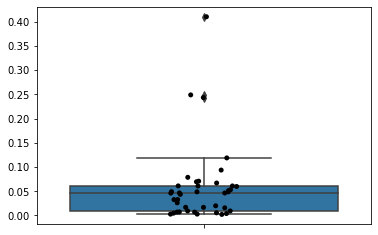

In [42]:
from collections import Counter

# Create a dictionary where the keys = the parent names and the values = Pnew
GFP_pnew_dict = {}
RFP_pnew_dict = {}

# Two lists: GFP and RFP-active. These lists
GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']

# Calculate the Pnew for GFP (top strand)
print("GFP....")
for i, parent in enumerate(parent_seq_ids):

    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]

    scores = sub_df['GFP_mean'].to_list()
    scores = [np.round(n) for n in scores]

    # Get the scores counts:
    score_counts = Counter(scores)

    # Save them as a dictionary (for stacked barplots later)
    sub_dictionary = {}
    sub_dictionary['none'] = score_counts[1]
    sub_dictionary['low'] = score_counts[2]
    sub_dictionary['moderate'] = score_counts[3]
    sub_dictionary['high'] = score_counts[4]

    ID_pnew = (score_counts[2] + score_counts[3] + score_counts[4]) / len(scores)
    GFP_pnew_dict[parent] = ID_pnew

        
print("RFP....")
for i, parent in enumerate(parent_seq_ids):

    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]

    scores = sub_df['RFP_mean'].to_list()
    scores = [np.round(n) for n in scores]

    # Get the scores counts:
    score_counts = Counter(scores)
    #print(f'{parent}: {score_counts}')

    # Save them as a dictionary (for stacked barplots later)
    sub_dictionary = {}
    sub_dictionary['none'] = score_counts[1]
    sub_dictionary['low'] = score_counts[2]
    sub_dictionary['moderate'] = score_counts[3]
    sub_dictionary['high'] = score_counts[4]

    ID_pnew = (score_counts[2] + score_counts[3] + score_counts[4]) / len(scores)
    RFP_pnew_dict[parent] = ID_pnew
    #print(f'{parent}:{ID_pnew}')
        
pnews = []
for i, parent in enumerate(parent_seq_ids):
    if parent not in GFP_active:
        pnews.append(GFP_pnew_dict[parent])
        
    if parent not in RFP_active:
        pnews.append(RFP_pnew_dict[parent])
        
sns.boxplot(y=pnews)
sns.stripplot(y=pnews, color='black')

#plt.savefig('output_figures/Fig1_D.pdf')

In [374]:
print(len(pnews))
print(np.median(pnews))
print(np.std(pnews))
print(np.min(pnews))
print(np.max(pnews))

40
0.04612550356353583
0.07760602102980312
0.00199700449326011
0.41017629993305066


### 1E) Pnew relates to wild-type promoter levels

[0.0, 0.0, 1.4268104475689825e-09]


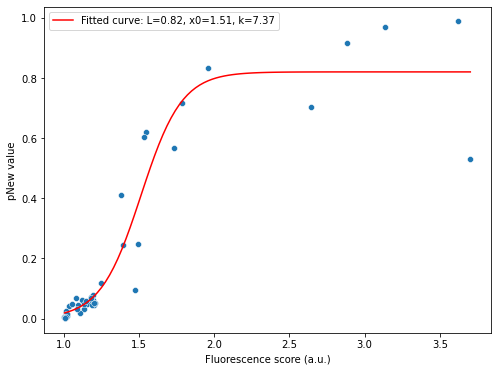

In [43]:
# Define the sigmoid function
from scipy.stats import linregress
import scipy.stats as stats
from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Two lists: GFP and RFP-active. These lists
GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']

# DF with just the parents:
sub_df = df[df['distance'] == 0].copy()

# Get a dictionary for the values:
GFP_parents = {}
RFP_parents = {}
for parent in parent_seq_ids:
    for i, row in sub_df.iterrows():
        if row['matched_pi'] == parent:
            GFP_parents[parent] = row['GFP_mean']
            RFP_parents[parent] = row['RFP_mean']

pnews = []
parent_fluorescence = []
# Get the pnews and fluorescence scores in the same list order
fluors = ['GFP', 'RFP']
for Fluor in fluors:
    for parent in parent_seq_ids:
        
        if Fluor == 'GFP':
            pnews.append(GFP_pnew_dict[parent])
            parent_fluorescence.append(GFP_parents[parent])
        elif Fluor == 'RFP':
            pnews.append(RFP_pnew_dict[parent])
            parent_fluorescence.append(RFP_parents[parent])

x = np.array(parent_fluorescence)
y = np.array(pnews)

# Initial guess for parameters [L, x0, k]
p0 = [1, np.median(x), 1]

# Fit the sigmoid model to the data
popt, pcov = curve_fit(sigmoid, x, y, p0, method='dogbox')
L_fit, x0_fit, k_fit = popt

# Generate points to plot the fitted curve
x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = sigmoid(x_fit, L_fit, x0_fit, k_fit)

# Extract fitted parameters and their standard errors
L_fit, x0_fit, k_fit = popt
perr = np.sqrt(np.diag(pcov))

# Calculate t-values and p-values
t_values = popt / perr
p_values = [2 * (1 - stats.t.cdf(np.abs(t_val), len(x) - len(popt))) for t_val in t_values]

print(p_values)

# Plot the original data as a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)

# Plot the fitted sigmoid curve
plt.plot(x_fit, y_fit, color='red', label=f'Fitted curve: L={L_fit:.2f}, x0={x0_fit:.2f}, k={k_fit:.2f}')

# Customize the plot
plt.xlabel('Fluorescence score (a.u.)')
plt.ylabel('pNew value')
plt.legend()

#plt.savefig('sigmoid_pnew.pdf')

### 1F) Pnew does not correlate with -10 or -35 box counts in non-promoter parents

In [40]:
fluors = ['GFP', 'RFP']

ten_counts = []
thirtyfive_counts = []

for Fluor in fluors:
    for ID in parent_seq_ids:
        parent = parents_dict[ID]
        dict_10_35 = wild_type_boxes(Fluor, 6, parent)

        ten_counts.append(len(dict_10_35['minus10']))
        thirtyfive_counts.append(len(dict_10_35['minus35']))

P-value: 0.515152304701217
R-squared: 0.011230980601372901


<AxesSubplot:>

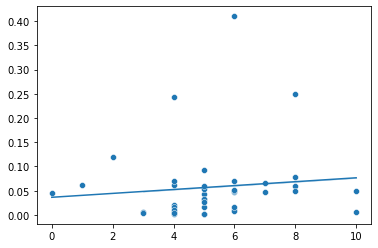

In [58]:
from scipy.stats import linregress
import scipy.stats as stats

y = [] # Pnew
x = [] # -10 box count

for Fluor in fluors:
    for ID in parent_seq_ids:

        if Fluor == 'GFP' and ID in GFP_active:
            pass
        elif Fluor == 'RFP' and ID in RFP_active:
            pass
        else:
            
            if Fluor == 'GFP':
                y.append(GFP_pnew_dict[ID])
            elif Fluor == 'RFP':
                y.append(RFP_pnew_dict[ID])

            parent = parents_dict[ID]
            dict_10_35 = wild_type_boxes(Fluor, 6, parent)
            x.append(len(dict_10_35['minus10']))

sns.scatterplot(x=x,y=y)

x = np.array(x)
y = np.array(y)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
#print(slope)
#print(intercept)
#print(r_value)
print(f'P-value: {p_value}')
#print(std_err)

# Calculate predicted y values
y_pred = (slope * x) + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print("R-squared:", r_squared)
sns.lineplot(x=x, y=y_pred)
#plt.savefig('output_figures/Fig_1F_10s.pdf')

P-value: 0.6524395096474721
R-squared: 0.00539390964900026


<AxesSubplot:>

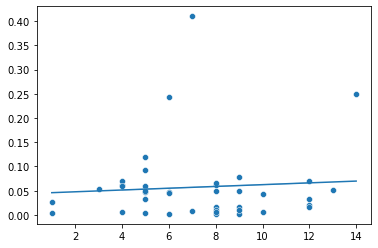

In [60]:
from scipy.stats import linregress
import scipy.stats as stats

y = [] # Pnew
x = [] # -35 box count

for Fluor in fluors:
    for ID in parent_seq_ids:

        if Fluor == 'GFP' and ID in GFP_active:
            pass
        elif Fluor == 'RFP' and ID in RFP_active:
            pass
        else:
            
            if Fluor == 'GFP':
                y.append(GFP_pnew_dict[ID])
            elif Fluor == 'RFP':
                y.append(RFP_pnew_dict[ID])

            parent = parents_dict[ID]
            dict_10_35 = wild_type_boxes(Fluor, 6, parent)
            x.append(len(dict_10_35['minus35']))


sns.scatterplot(x=x,y=y)

x = np.array(x)
y = np.array(y)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
#print(slope)
#print(intercept)
#print(r_value)
print(f'P-value: {p_value}')
#print(std_err)

# Calculate predicted y values
y_pred = (slope * x) + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print("R-squared:", r_squared)
sns.lineplot(x=x, y=y_pred)
#plt.savefig('output_figures/Fig_1F_35s.pdf')

## Figure 2) The majority of promoters emerge and evolve within a subset of preexisting promoter motifs

### 2B) P19-GFP mutual (promoter)

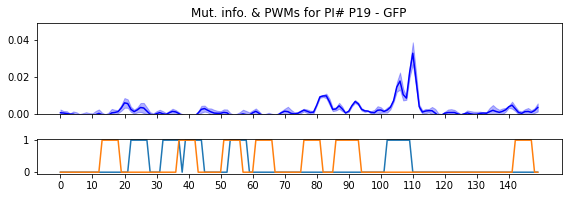

In [49]:
### KWARGS
ID = 'P19'
Fluor = 'GFP'
blur = 1
window_size = 6

import itertools
from scipy.ndimage import gaussian_filter

# Determine whether the lineplot is red or blue
if Fluor == 'RFP':
    farbe = 'red'
elif Fluor == 'GFP':
    farbe = 'blue'
    
# ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
means, std_devs = calculate_mutual_information(ID, Fluor, blur)

# Plot individual...
x_values = range(len(means))

# Create a 2-row, 1-column subplot and select the top box
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
top_ax = axes[0]

# Customize x-axis ticks and annotations (every 10 units)
top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

# Create the Seaborn line plot for means in the top subplot
sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

# Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                 [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

# The y-limit
top_ax.set_ylim([0, 1.5*np.max(means)])

# Plot the -10 and -35 boxes
bot_ax = axes[1]
WT_pwms(Fluor,window_size,ID,False)

# Adjust subplot layout
plt.tight_layout()

# Save
#plt.savefig('output_figures/Fig2_B.pdf')

### 2C) Hotspot overlap with motifs

In [384]:
hotspot_df = pd.read_csv("Data_S3.csv")

pd.options.mode.chained_assignment = None  # Disable the warning

GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']

status_list = []
for i, row in hotspot_df.iterrows():
    
    # If active...
    if row['Parent'] in GFP_active and row['Orientation'] == 'GFP' or row['Parent'] in RFP_active and row['Orientation'] == 'RFP':
        status = 'active'
    # If inactive...
    else:
        status = 'inactive'
        
    # Append to list
    status_list.append(status)
    
# Add list to dictionary
hotspot_df['status'] = status_list

active_hotspots = hotspot_df[((hotspot_df['status'] == 'active'))]
inactive_hotspots = hotspot_df[((hotspot_df['status'] == 'inactive'))]

### Active hotspots - not scrambled

{'Category': ['Promoter activity'], '-10': [5], '-35': [11], '-10 and -35': [6], 'None': [12]}


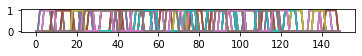

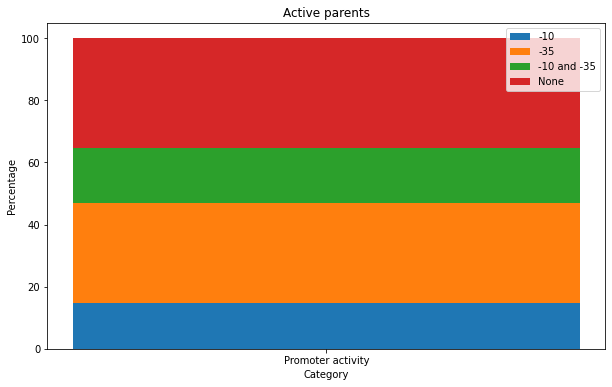

In [385]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in active_hotspots.iterrows():

    # Define the variables from each row
    ID = row['Parent']
    Fluor = row['Orientation']
    index = int(row['Coordinate'])

    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'

    # Get the PWMs for the parent sequence (it is calculated every iteration, I know it's not efficient...)
    PWM_indexes = WT_pwms(Fluor, 6, ID, False)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']

    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'

    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'

    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
active_hotspots['overlap_10_same'] = overlap_10
active_hotspots['overlap_35_same'] = overlap_35
active_hotspots['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

# Format data for stacked barplot
data = {
    'Category': ['Promoter activity'],
    '-10': [ten_only_count],
    '-35': [thirtyfive_only_count],
    '-10 and -35': [both_count],
    'None':[none_count]
}

print(data)

# Create DataFrame
barplot_df = pd.DataFrame(data)

# Calculate percentage for each group
df_perc = barplot_df.set_index('Category').apply(lambda x: x / x.sum() * 100, axis=1)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
bottom = 0
for col in df_perc.columns:
    plt.bar(df_perc.index, df_perc[col], label=col, bottom=bottom)
    bottom += df_perc[col]

# Add labels and legend
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Active parents')
plt.legend()

# Show plot
#plt.savefig('output_figures/2C_WT_active.pdf')

### Active hotspots - scrambled

{'Category': ['Promoter activity'], '-10': [3], '-35': [4], '-10 and -35': [1], 'None': [26]}


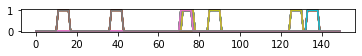

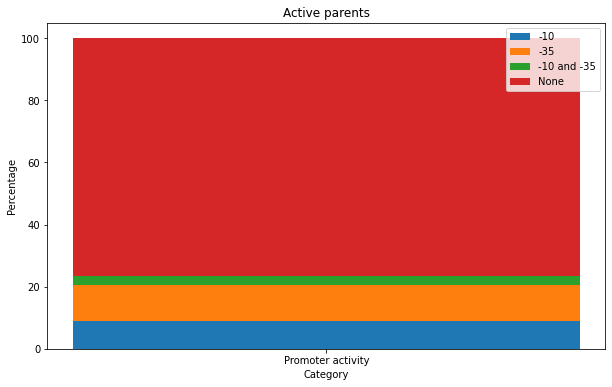

In [387]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in active_hotspots.iterrows():

    # Define the variables from each row
    ID = row['Parent']
    Fluor = row['Orientation']
    index = int(row['Coordinate'])

    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'

    # Get the PWMs for the parent sequence
    PWM_indexes = WT_pwms(Fluor, 6, ID, True) #The randomization happens here, but the random seed is fixed. Scrambling is consistent between loops.
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']

    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'

    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'

    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
active_hotspots['overlap_10_same'] = overlap_10
active_hotspots['overlap_35_same'] = overlap_35
active_hotspots['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

# Format data for stacked barplot
data = {
    'Category': ['Promoter activity'],
    '-10': [ten_only_count],
    '-35': [thirtyfive_only_count],
    '-10 and -35': [both_count],
    'None':[none_count]
}

print(data)

# Create DataFrame
barplot_df = pd.DataFrame(data)

# Calculate percentage for each group
df_perc = barplot_df.set_index('Category').apply(lambda x: x / x.sum() * 100, axis=1)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
bottom = 0
for col in df_perc.columns:
    plt.bar(df_perc.index, df_perc[col], label=col, bottom=bottom)
    bottom += df_perc[col]

# Add labels and legend
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Active parents')
plt.legend()

# Show plot
#plt.savefig('output_figures/2C_active_scrambled.pdf')

### Inactive parents hotspots - not scrambled

{'Category': ['A'], '-10': [9], '-35': [9], '-10 and -35': [5], 'None': [11]}


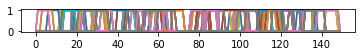

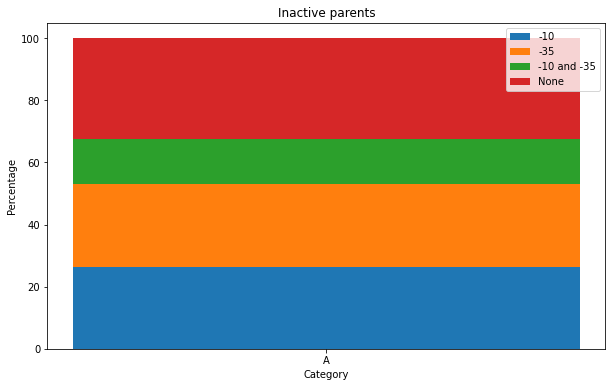

In [388]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in inactive_hotspots.iterrows():

    # Define the variables from each row
    ID = row['Parent']
    Fluor = row['Orientation']
    index = int(row['Coordinate'])

    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'

    # Get the PWMs for the parent sequence (it is calculated every iteration, I know it's not efficient...)
    PWM_indexes = WT_pwms(Fluor, 6, ID, False)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']

    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'

    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'

    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
inactive_hotspots['overlap_10_same'] = overlap_10
inactive_hotspots['overlap_35_same'] = overlap_35
inactive_hotspots['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

# Format data for stacked barplot
data = {
    'Category': ['A'],
    '-10': [ten_only_count],
    '-35': [thirtyfive_only_count],
    '-10 and -35': [both_count],
    'None':[none_count]
}

print(data)

# Create DataFrame
barplot_df = pd.DataFrame(data)

# Calculate percentage for each group
df_perc = barplot_df.set_index('Category').apply(lambda x: x / x.sum() * 100, axis=1)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
bottom = 0
for col in df_perc.columns:
    plt.bar(df_perc.index, df_perc[col], label=col, bottom=bottom)
    bottom += df_perc[col]

# Add labels and legend
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Inactive parents')
plt.legend()

# Show plot
#plt.savefig('output_figures/2C_inactive_WT.pdf')

### Inactive parents hotspots - scrambled

{'Category': ['Promoter activity'], '-10': [8], '-35': [3], '-10 and -35': [2], 'None': [21]}


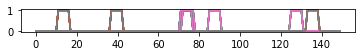

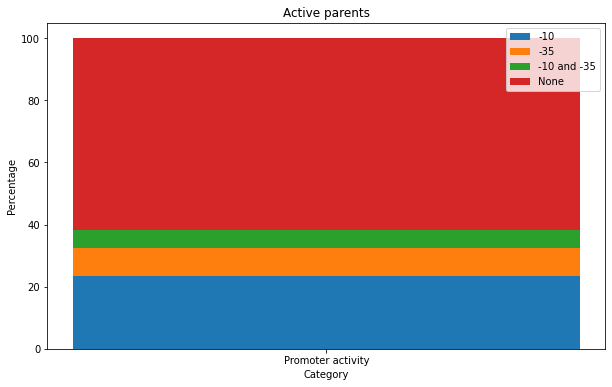

In [389]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in inactive_hotspots.iterrows():

    # Define the variables from each row
    ID = row['Parent']
    Fluor = row['Orientation']
    index = int(row['Coordinate'])

    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'

    # Get the PWMs for the parent sequence
    PWM_indexes = WT_pwms(Fluor, 6, ID, True)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']

    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'

    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'

    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
active_hotspots['overlap_10_same'] = overlap_10
active_hotspots['overlap_35_same'] = overlap_35
active_hotspots['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

# Format data for stacked barplot
data = {
    'Category': ['Promoter activity'],
    '-10': [ten_only_count],
    '-35': [thirtyfive_only_count],
    '-10 and -35': [both_count],
    'None':[none_count]
}

print(data)

# Create DataFrame
barplot_df = pd.DataFrame(data)

# Calculate percentage for each group
df_perc = barplot_df.set_index('Category').apply(lambda x: x / x.sum() * 100, axis=1)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
bottom = 0
for col in df_perc.columns:
    plt.bar(df_perc.index, df_perc[col], label=col, bottom=bottom)
    bottom += df_perc[col]

# Add labels and legend
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Active parents')
plt.legend()

# Show plot
#plt.savefig('output_figures/2C_inactive_scrambled.pdf')

### Chi-squared tests

In [390]:
from scipy.stats import chisquare

# Observed and expected values
observed = [5,11,6,12] # actual values
expected = [3,4,1,26] # scrambled values

# Perform the chi-squared test
chi_squared_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Output the results
print(f"Chi-squared Statistic: {chi_squared_stat:.4f}")
print(f"P-value: {p_value}")

# Decision based on significance level (e.g., 0.05)
significance_level = 0.05
if p_value < significance_level:
    print("Result: Reject the null hypothesis (significant difference).")
else:
    print("Result: Fail to reject the null hypothesis (no significant difference).")

Chi-squared Statistic: 46.1218
P-value: 5.343184637381934e-10
Result: Reject the null hypothesis (significant difference).


In [391]:
from scipy.stats import chisquare

# Observed and expected values
observed = [9,9,5,11] # actual values
expected = [8,3,2,21] # scrambled values

# Perform the chi-squared test
chi_squared_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Output the results
print(f"Chi-squared Statistic: {chi_squared_stat:.4f}")
print(f"P-value: {p_value}")

# Decision based on significance level (e.g., 0.05)
significance_level = 0.05
if p_value < significance_level:
    print("Result: Reject the null hypothesis (significant difference).")
else:
    print("Result: Fail to reject the null hypothesis (no significant difference).")

Chi-squared Statistic: 21.3869
P-value: 8.748819091668226e-05
Result: Reject the null hypothesis (significant difference).


In [67]:
from scipy.stats import chisquare

# Observed and expected values
observed = [5,11,6,12] # active values
expected = [9,9,5,11] # inactive values

# Perform the chi-squared test
chi_squared_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Output the results
print(f"Chi-squared Statistic: {chi_squared_stat:.4f}")
print(f"P-value: {p_value}")

# Decision based on significance level (e.g., 0.05)
significance_level = 0.05
if p_value < significance_level:
    print("Result: Reject the null hypothesis (significant difference).")
else:
    print("Result: Fail to reject the null hypothesis (no significant difference).")

Chi-squared Statistic: 2.5131
P-value: 0.4729226346406069
Result: Fail to reject the null hypothesis (no significant difference).


In [68]:
from scipy.stats import chisquare

# Observed and expected values
observed = [3,4,1,26] # active scrambled values
expected = [8,3,2,21] # inactive scrambled values

# Perform the chi-squared test
chi_squared_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Output the results
print(f"Chi-squared Statistic: {chi_squared_stat:.4f}")
print(f"P-value: {p_value}")

# Decision based on significance level (e.g., 0.05)
significance_level = 0.05
if p_value < significance_level:
    print("Result: Reject the null hypothesis (significant difference).")
else:
    print("Result: Fail to reject the null hypothesis (no significant difference).")

Chi-squared Statistic: 5.1488
P-value: 0.1612193004455466
Result: Fail to reject the null hypothesis (no significant difference).


In [408]:
### How many -10 and -35 boxes in the parents and what percent overlap with the hotspots?

ten_overlap = 0
thirtyfive_overlap = 0

total_10s = 0
total_35s = 0

for Fluor in fluors:
    for ID in parent_seq_ids:

        # Get the parent DNA sequence
        parent = parents_dict[ID]
        
        # Get the -10 and -35 PWM coordinates as lists
        parent_10s_35s = wild_type_boxes(Fluor, 6, parent)
        parent_10s = parent_10s_35s['minus10']
        parent_35s = parent_10s_35s['minus35']
        
        # Get the total amount of 10s and 35s in the parents
        total_10s += len(parent_10s)
        total_35s += len(parent_35s)
        
        # Create a subset of the hotspot dataframe which only has the appropriate parent and fluor:
        sub_hotspot_df = hotspot_df[((hotspot_df['Parent'] == ID) & (hotspot_df['Orientation'] == Fluor))]
        
        # Get a list of the hotspot coordinates
        hotspot_coordinates = sub_hotspot_df['Coordinate']
        
        # Loop through each 10 coordinate
        for ten in parent_10s:
            begin, end = ten-3, ten+9 # Define the beginning adn end of the coordinate # Within +/- 3 bp
            
            # Loop through each hotspot coordinate
            for coordinate in hotspot_coordinates:
                if int(coordinate) >= begin and coordinate <= end: # Look if the hotspot coordinate is within begin, end
                    ten_overlap += 1
                    
        # Loop through each 35 coordinate
        for thirtyfive in parent_35s:
            begin, end = thirtyfive-3, thirtyfive+9 # Within +/- 3 bp
            
            for coordinate in hotspot_coordinates:
                if int(coordinate) >= begin and coordinate <= end:
                    thirtyfive_overlap +=1
        
print(f'{ten_overlap} -10 boxes overlap with hotspots.')
print(f'{thirtyfive_overlap} -35 boxes overlap with hotspots.')
print(f'There are {total_10s} -10 boxes in the parent seqeunces.')
print(f'There are {total_35s} -35 boxes in the parent sequences.')
print(f'{100*ten_overlap/total_10s}% of the -10s overlap with a hotspot.')
print(f'{100*thirtyfive_overlap/total_35s}% of the -35s overlap with a hotspot.')

37 -10 boxes overlap with hotspots.
43 -35 boxes overlap with hotspots.
There are 266 -10 boxes in the parent seqeunces.
There are 352 -35 boxes in the parent sequences.
13.909774436090226% of the -10s overlap with a hotspot.
12.215909090909092% of the -35s overlap with a hotspot.


### 2D) P3-RFP (non-promoter)

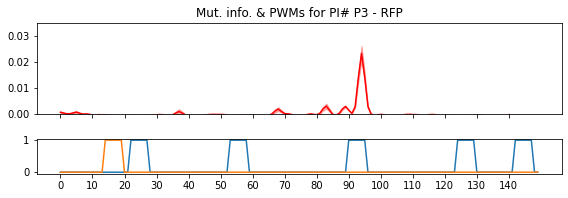

In [69]:
### KWARGS (you can change these for the other promoter islands as you wish)
ID = "P3"
Fluor = 'RFP'
blur = 1
window_size = 6

import itertools
from scipy.ndimage import gaussian_filter

# Determine whether the lineplot is red or blue
if Fluor == 'RFP':
    farbe = 'red'
elif Fluor == 'GFP':
    farbe = 'blue'
    
# ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
means, std_devs = calculate_mutual_information(ID, Fluor, blur)

# Plot individual...
x_values = range(len(means))

# Create a 2-row, 1-column subplot and select the top box
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
top_ax = axes[0]

# Customize x-axis ticks and annotations (every 10 units)
top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

# Create the Seaborn line plot for means in the top subplot
sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

# Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                 [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

# The y-limit
top_ax.set_ylim([0, 1.5*np.max(means)])

# Plot the -10 and -35 boxes
bot_ax = axes[1]
WT_pwms(Fluor,window_size,ID, False)

# Adjust subplot layout
plt.tight_layout()

# Save
#plt.savefig('output_figures/Fig2_D.pdf')

### 2E) P18-GFP (non-promoter)

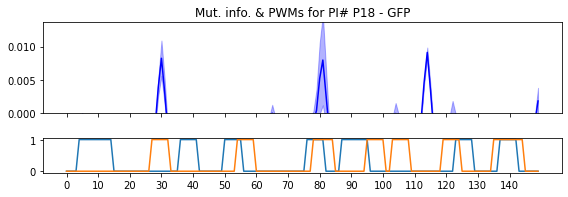

In [70]:
### KWARGS (you can change these for the other promoter islands as you wish)
ID = "P18"
Fluor = 'GFP'
blur = 1
window_size = 6

import itertools
from scipy.ndimage import gaussian_filter

# Determine whether the lineplot is red or blue
if Fluor == 'RFP':
    farbe = 'red'
elif Fluor == 'GFP':
    farbe = 'blue'
    
# ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
means, std_devs = calculate_mutual_information(ID, Fluor, blur)

# Plot individual...
x_values = range(len(means))

# Create a 2-row, 1-column subplot and select the top box
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
top_ax = axes[0]

# Customize x-axis ticks and annotations (every 10 units)
top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

# Create the Seaborn line plot for means in the top subplot
sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

# Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                 [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

# The y-limit
top_ax.set_ylim([0, 1.5*np.max(means)])

# Plot the -10 and -35 boxes
bot_ax = axes[1]
WT_pwms(Fluor,window_size,ID, False)

# Adjust subplot layout
plt.tight_layout()

# Save
#plt.savefig('output_figures/Fig2_E.pdf')

## Figure 3) Gaining -10 and -35 boxes rarely creates de-novo promoters

### 3B) Number of gained -10 and -35 boxes per library
Note: This code runs very slowly. I have pasted the outputs in the next cell if you don't wish to run it.

In [ ]:
GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']
fluors = ['GFP', 'RFP']

# These lists keep track for all elements, the number of additional -10 and -35 boxes gained in the dataset
additional_10s_acquired = []
additional_35s_acquired = []
combinations = []

for parent in parent_seq_ids:
    for Fluor in fluors:
        
        if Fluor == 'GFP' and parent in GFP_active or Fluor == 'RFP' and parent in RFP_active:
            pass
        else:
        
            print(parent, Fluor)
            combinations.append((parent, Fluor))

            # Find the locations of all -10 and -35 box motifs in the daughter sequences
            gained_10s, gained_35s = gained_motifs_count(parent, Fluor)

            # Get the wild-type -10 and -35 box motifs:
            WT_10_35_dict = WT_pwms(Fluor, 6, parents_dict[parent])

            # Get the unique -10 and -35 boxes
            new_10s = [item for item in gained_10s if item not in WT_10_35_dict['minus10']]
            new_35s = [item for item in gained_35s if item not in WT_10_35_dict['minus35']]

            # Append the lengths to the master lists
            additional_10s_acquired.append(len(new_10s))
            additional_35s_acquired.append(len(new_35s))
        
print("done.")

In [62]:
additional_10s_acquired = [52, 59, 46, 46, 47, 41, 36, 41, 49, 55, 26, 40, 32, 31, 31, 43, 37, 36, 38, 52, 47, 43, 40, 32, 38, 23, 32, 32, 43, 38, 37, 37, 31, 33, 35, 36, 36, 34, 41, 36]
additional_35s_acquired = [53, 56, 45, 45, 49, 30, 39, 39, 41, 46, 44, 41, 37, 38, 36, 45, 30, 33, 38, 45, 47, 41, 39, 35, 49, 29, 30, 37, 39, 43, 38, 35, 29, 34, 37, 33, 41, 38, 33, 39]
combinations = [('P1', 'GFP'), ('P1', 'RFP'), ('P2', 'GFP'), ('P2', 'RFP'), ('P3', 'GFP'), ('P3', 'RFP'), ('P4', 'GFP'), ('P4', 'RFP'), ('P5', 'GFP'), ('P5', 'RFP'), ('P6', 'GFP'), ('P7', 'GFP'), ('P7', 'RFP'), ('P8', 'GFP'), ('P8', 'RFP'), ('P9', 'GFP'), ('P9', 'RFP'), ('P10', 'GFP'), ('P10', 'RFP'), ('P11', 'GFP'), ('P11', 'RFP'), ('P12', 'GFP'), ('P13', 'GFP'), ('P14', 'GFP'), ('P14', 'RFP'), ('P15', 'GFP'), ('P15', 'RFP'), ('P16', 'GFP'), ('P16', 'RFP'), ('P17', 'GFP'), ('P17', 'RFP'), ('P18', 'GFP'), ('P21', 'GFP'), ('P22', 'RFP'), ('P23', 'GFP'), ('P23', 'RFP'), ('P24', 'GFP'), ('P24', 'RFP'), ('P25', 'GFP'), ('P25', 'RFP')]

Mean of additional_10s_acquired: 39.05
Sum of additional_10s_acquired: 1562
Mean of additional_35s_acquired: 39.4
Sum of additional_35s_acquired: 1576


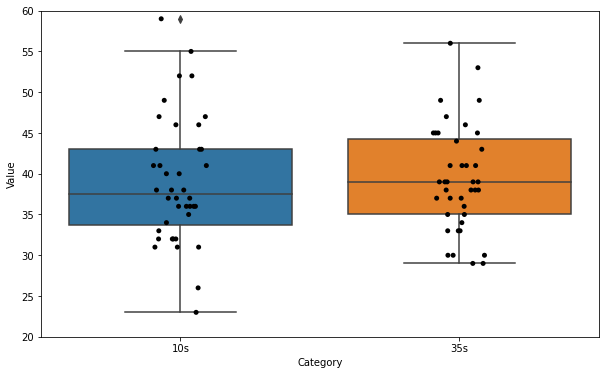

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a new figure
plt.figure(figsize=(10, 6))

# Combine data into a DataFrame for easier plotting
data = pd.DataFrame({
    'Value': additional_10s_acquired + additional_35s_acquired,
    'Category': ['10s'] * len(additional_10s_acquired) + ['35s'] * len(additional_35s_acquired)
})

# Create the boxplot and stripplot
sns.boxplot(x='Category', y='Value', data=data)
sns.stripplot(x='Category', y='Value', data=data, color='black', jitter=True)

# Set y-axis limits
plt.ylim(20, 60)

# Show means and sums
mean_10s = np.mean(additional_10s_acquired)
sum_10s = np.sum(additional_10s_acquired)
mean_35s = np.mean(additional_35s_acquired)
sum_35s = np.sum(additional_35s_acquired)

print(f'Mean of additional_10s_acquired: {mean_10s}')
print(f'Sum of additional_10s_acquired: {sum_10s}')
print(f'Mean of additional_35s_acquired: {mean_35s}')
print(f'Sum of additional_35s_acquired: {sum_35s}')

# Display the plot
#plt.savefig('gained_motifs_per_parent.pdf')

### 3D) Fluorescence changes in non-promoter parent sequences

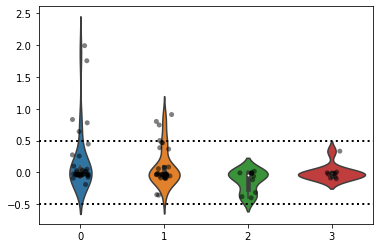

In [414]:
import pandas as pd
output_df = pd.read_csv("Data_S4.csv")

GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']

gain_10_same = []
gain_35_same = []
lose_10_same = []
lose_35_same = []

hotspots = []
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:
        #print(f'{ID}: {Fluor}')
        pass
    
    else:
        
        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change >= 0.5:
                hotspots.append(out_row['Hotspot_ID'])
            
            # Gain same strand
            if gain_loss == 'gain':
                if PWM == 'minus10':
                    gain_10_same.append(change)
                elif PWM == 'minus35':
                    gain_35_same.append(change)

            elif gain_loss == 'loss':
                if PWM == 'minus10':
                    lose_10_same.append(change)
                elif PWM == 'minus35':
                    lose_35_same.append(change)
            
# Create a violinplot
all_data = [gain_10_same, gain_35_same, lose_10_same, lose_35_same]
sns.violinplot(data=all_data)
sns.stripplot(data=all_data, color='black', jitter=True, alpha=0.5)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)

### 3F) P16-RFP gain -10 box 17 bp downstream of -35 box

-1.9900827531853418
4163
49
TAAACA
TAAACT
0.4386348
7.279098
q=7.64073808458046e-32


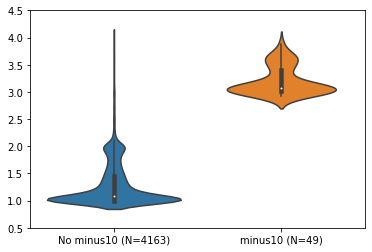

In [443]:
### KWARGS
orientation = 'bottom'
ID = "P16"
Fluor = 'RFP'
TF = 'minus10'
window = [126,132]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### 3F prime) Point-mutation fluorescence fold-change

In [111]:
import pandas as pd

plate_df = pd.read_csv("Data_S6.csv")

# Create a list of the unique parents
parents = plate_df['parent'].to_list()
parents = list(set(parents))
print(parents)

# Create a list of the uniqe constructs
constructs = plate_df['construct'].to_list()
constructs = list(set(constructs))
print(constructs)

['P8', 'P3', 'P16', 'P22', 'P9', 'P19', 'P13', 'pass', 'P1', 'P12', 'P6']
['S12F', 'P16', 'S8K', 'S9G10', 'P19', 'S8F', 'S8H', 'S10F', 'S8D', 'S9E', '4D', 'P22', 'S12E', 'S9D', 'S10B', 'S9I10', '4G', 'P6', 'pass', 'S10C', 'P9', 'P1', 'S9I35', '3F', 'S10A', 'P12', '3H', 'S10G', 'P3', 'P8', 'S8J', 'S8L', 'S10D', 'S9B', 'S9G35', 'P13', 'S8B', 'S10E']


fluorescence increases 11.163572523207895-fold
2479.549719
2770.939141
2965.939533

37135.47847
31271.50011
31534.14406


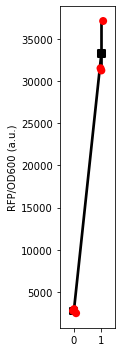

In [113]:
plot_plate_reader('P16', '3F', 'RFP')

### 3H) P1-RFP gain -35 box 18 bp upstream of -10 box

-0.7444444444444445
62689
128
ATGAGT
TTGAGT
0
3.929902
q=4.2503669633628745e-42


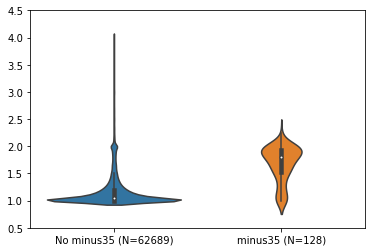

In [444]:
### KWARGS
orientation = 'bottom'
ID = "P1"
Fluor = 'RFP'
TF = 'minus35'
window = [107, 113]
gain_loss = 'gain'

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### 3H prime) Point-mutation fluorescence fold-change

fluorescence increases 2.02876987814297-fold
3698.591812
2259.036145
2548.749261

7096.607365
10442.62732
8224.624405


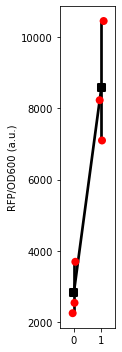

In [114]:
plot_plate_reader('P1', '3H', 'RFP')

## Figure 4) Gaining -10 and -35 boxes modulates promoter activity.

### 4A) Fluorescence changes from losing -10 and -35 boxes in parents with promoter activity

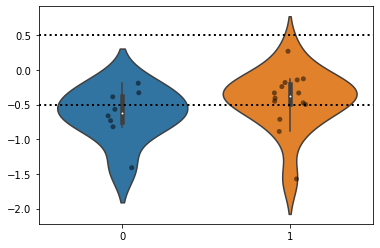

In [71]:
gain_10_same = []
gain_35_same = []
lose_10_same = []
lose_35_same = []

hotspots = []
GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']

output_df = pd.read_csv("Data_S4.csv")
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Only look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
                        
            # Gain same strand
            if gain_loss == 'gain':
                if PWM == 'minus10':
                    gain_10_same.append(change)
                elif PWM == 'minus35':
                    gain_35_same.append(change)

            elif gain_loss == 'loss':
                if PWM == 'minus10':
                    lose_10_same.append(change)
                elif PWM == 'minus35':
                    lose_35_same.append(change)
            
# Create a violinplot
#all_data = [gain_10_same, gain_35_same, lose_10_same, lose_35_same]
all_data = [lose_10_same, lose_35_same]
sns.violinplot(data=all_data)
sns.stripplot(data=all_data, color='black', jitter=True, alpha=0.5)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)
#plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)
#plt.savefig('output_figures/Fig4_A.pdf')

### 4D) -10 box homo-gain

-0.7797381971076858
5866
24
CAATGT
TAATGT
0
5.5007014
q=5.845502919318672e-13


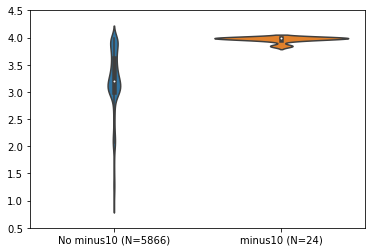

In [452]:
### KWARGS
orientation = 'bottom'
ID = "P12"
Fluor = 'RFP'
TF = 'minus10'
window = [136, 142]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### 4D prime) Point-mutation fluorescence fold-change

fluorescence increases 0.27204195828842465-fold
36019.98017
34376.15894
35009.73339

47426.45698
43756.10205
42898.13344


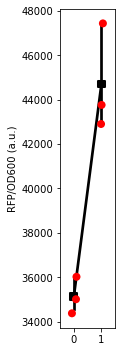

In [115]:
plot_plate_reader('P12','4D','RFP')

### 4E) Fluorescence changes from gaining -10 and -35 boxes in parents with promoter activity

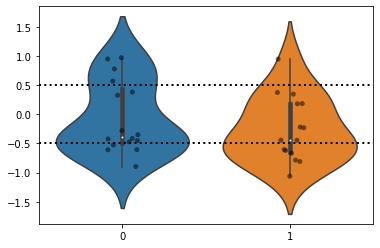

In [74]:
gain_10_same = []
gain_35_same = []
lose_10_same = []
lose_35_same = []

hotspots = []
GFP_active = ['P22', 'P19', 'P20']
RFP_active = ['P6','P12','P13','P18','P21','P19','P20']

output_df = pd.read_csv("Data_S4.csv")
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Only look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
                        
            # Gain same strand
            if gain_loss == 'gain':
                if PWM == 'minus10':
                    gain_10_same.append(change)
                elif PWM == 'minus35':
                    gain_35_same.append(change)

            elif gain_loss == 'loss':
                if PWM == 'minus10':
                    lose_10_same.append(change)
                elif PWM == 'minus35':
                    lose_35_same.append(change)
            
# Create a violinplot
all_data = [gain_10_same, gain_35_same]
sns.violinplot(data=all_data)
sns.stripplot(data=all_data, color='black', jitter=True, alpha=0.5)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)

### 4G) -10 box hetero-gain

0.895833333333333
2537
25
TGTTTT
TATTTT
0
6.0907574
q=7.287068950024896e-07


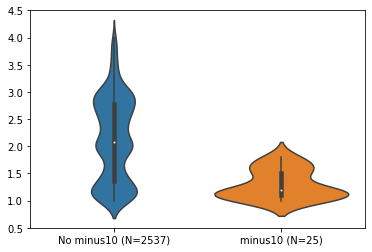

In [454]:
### KWARGS
orientation = 'top'
ID = "P22"
Fluor = 'GFP'
TF = 'minus10'
window = [111, 117]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### 4G prime) Point-mutation fluorescence fold-change

fluorescence increases 12.66691626202398-fold
3080.393765
3071.435189
2885.776383

44585.56514
48335.19657
30595.43364


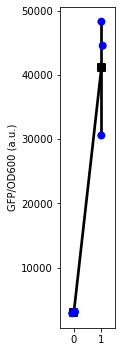

In [116]:
plot_plate_reader('4G','P22','GFP')

## Figure 5) Histone-like nucleoid-structuring protein (H-NS) represses P12-RFP and P22-GFP

### 5A) Mean fluorescence differences: delta hns vs WT (wild-type) backgrounds

In [81]:
#### import numpy as np

parents = []
for n in range(1,26):
    parents.append("P" + str(n))
    
#hns_df = pd.read_csv("WT_PIs_HNS.csv")
hns_df = pd.read_csv("Data_S6.csv")

# GFP first
dh5a_GFP_parents = {} #keys = parent names, values = mean GFP fluorescence score
hns_GFP_parents = {} #keys = parent names, values = mean GFP fluorescence score

for parent in parents:
    
    individual_dh5a_values = []
    individual_hns_values = []
    
    for i, row in hns_df.iterrows():
        if parent in row['Name']:
            if 'dh5a' in row['Name']:
                individual_dh5a_values.append(row['GFP/OD'])
            elif 'hns' in row['Name']:
                individual_hns_values.append(row['GFP/OD'])
                
    dh5a_GFP_parents[parent] = np.mean(individual_dh5a_values)
    hns_GFP_parents[parent] = np.mean(individual_hns_values)
    
# RFP second
dh5a_RFP_parents = {} #keys = parent names, values = mean RFP fluorescence score
hns_RFP_parents = {} #keys = parent names, values = mean RFP fluorescence score

for parent in parents:
    
    individual_dh5a_values = []
    individual_hns_values = []
    
    for i, row in hns_df.iterrows():
        if parent in row['Name']:
            if 'dh5a' in row['Name']:
                individual_dh5a_values.append(row['RFP/OD'])
            elif 'hns' in row['Name']:
                individual_hns_values.append(row['RFP/OD'])
                
    dh5a_RFP_parents[parent] = np.mean(individual_dh5a_values)
    hns_RFP_parents[parent] = np.mean(individual_hns_values)
    
# Calculate differences
GFP_differences = []
RFP_differences = []
for parent in parents:

    GFP_difference = hns_GFP_parents[parent] - dh5a_GFP_parents[parent]
    GFP_differences.append(GFP_difference)

    RFP_difference =  hns_RFP_parents[parent] - dh5a_RFP_parents[parent]
    RFP_differences.append(RFP_difference)   

Text(0.5, 0, 'GFP/OD')

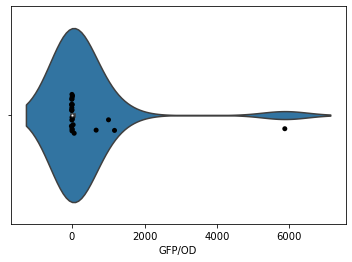

In [33]:
sns.stripplot(x=GFP_differences, color='black')
sns.violinplot(x=GFP_differences)
plt.xlabel("GFP/OD")
#plt.savefig("HNS_fluorescence_change_GFP.pdf")

Text(0.5, 0, 'RFP/OD')

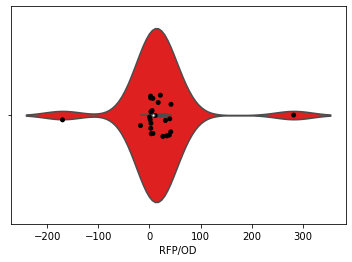

In [78]:
sns.stripplot(x=RFP_differences, color='black')
sns.violinplot(x=RFP_differences, color='red')
plt.xlabel("RFP/OD")
#plt.savefig("HNS_fluorescence_change_RFP.pdf")

### 5B) P22-GFP and P12-RFP are repressed by H-NS

T-statistic: -8.804225060062485
P-value: 1.1613093480651735e-08
fold_change: 1.5782864434727923.


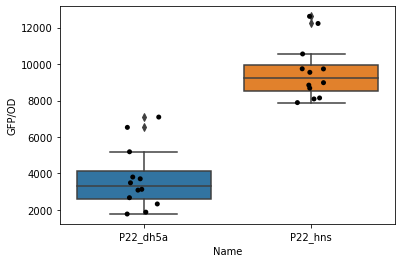

In [83]:
import scipy.stats as stats

sub_df = hns_df[hns_df['Name'].str.contains('P22')]
sns.stripplot(data=sub_df, x='Name', y='GFP/OD', color='black')
sns.boxplot(data=sub_df, x='Name', y='GFP/OD')
#plt.savefig("P22_hns_mutant_boxplots.pdf")

dh5a = []
hns = []
for i, row in sub_df.iterrows():
    if 'dh5a' in row['Name']:
        dh5a.append(row['GFP/OD'])
    elif 'hns' in row['Name']:
        hns.append(row['GFP/OD'])

# Perform the two-tailed t-test
t_stat, p_value = stats.ttest_ind(dh5a, hns)

# Output the result
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

fold_change = (np.mean(hns)-np.mean(dh5a))/np.mean(dh5a)
print(f'fold_change: {fold_change}.')

T-statistic: -10.574479397419918
P-value: 4.327448983432217e-10
fold_change: 0.5079930020965309.


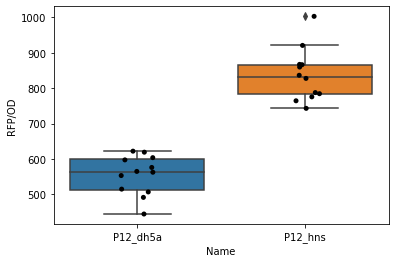

In [86]:
sub_df = hns_df[hns_df['Name'].str.contains('P12')]
sns.stripplot(data=sub_df, x='Name', y='RFP/OD', color='black')
sns.boxplot(data=sub_df, x='Name', y='RFP/OD')
#plt.savefig("P12_hns_mutant_boxplots.pdf")

dh5a = []
hns = []
for i, row in sub_df.iterrows():
    if 'dh5a' in row['Name']:
        dh5a.append(row['RFP/OD'])
    elif 'hns' in row['Name']:
        hns.append(row['RFP/OD'])

# Perform the two-tailed t-test
t_stat, p_value = stats.ttest_ind(dh5a, hns)

# Output the result
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
        
fold_change = (np.mean(hns)-np.mean(dh5a))/np.mean(dh5a)
print(f'fold_change: {fold_change}.')

### 5D) Significant median fluorescence gains from losing H-NS motifs

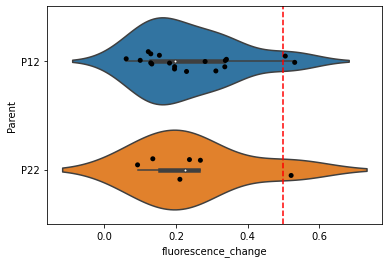

In [89]:
# Import Data S7
output_df = pd.read_csv("Data_S7.csv")

# Only interested in the results from P22-GFP and P12-RFP
sub_df = output_df[((output_df['Parent'] == 'P22') & (output_df['Fluor'] == 'GFP')) |
                     ((output_df['Parent'] == 'P12') & (output_df['Fluor'] == 'RFP'))]

# Violins and stripplots
sns.stripplot(data=sub_df, x='fluorescence_change', y='Parent', color='black')
sns.violinplot(data=sub_df, x='fluorescence_change', y='Parent')

# Add a vertical line at x = 0.5
plt.axvline(x=0.5, color='red', linestyle='--')

### 5E) Loss of H-NS motif in P22-GFP increases promoter activity

In [96]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio import motifs
import math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import itertools
import statsmodels.stats.multitest as smm

### Step 1) Import the PWM for H-NS
PSSM_txt_open = open('hns_instances.txt', 'r') # only instances from HNS
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
print("PSSMs and thresholds calculated!")

PSSMs and thresholds calculated!


0.5215986049522265
124
2438
TTATTYGTTATT
TTATTTGTTATT
0
5.1274624
q=0.0010655393651828


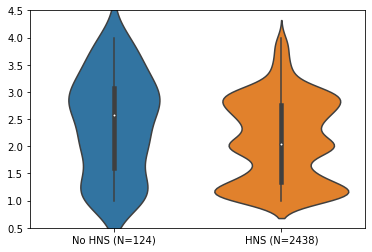

In [108]:
orientation = 'top'
ID = "P22"
Fluor = 'GFP'
TF = 'HNS'
window = [20, 32]
individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### 5F) Loss of H-NS motif in P12-RFP increases promoter activity

0.5053012239881554
432
5458
AAATCACATCTA
AAATCACATCTA
4.2700763
4.2700763
q=3.279032152049285e-40


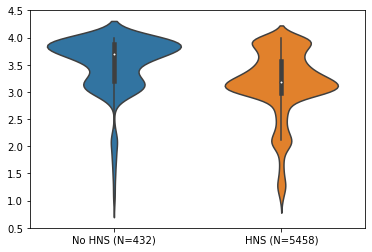

In [109]:
orientation = 'bottom'
ID = "P12"
Fluor = 'RFP'
TF = 'HNS'
window = [120, 132]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Orientation'] == 'bottom') & (output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### 5G) Loss of H-NS motif in P12-RFP increases promoter activity

0.5315505963832243
619
5271
TTAATTGCATTT
TTAATTGCATTT
4.417753
4.417753
q=4.417851378698681e-50


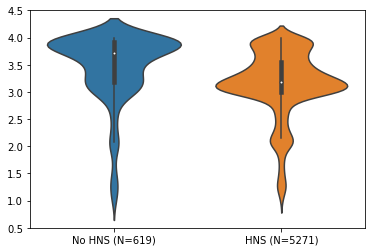

In [110]:
orientation = 'top'
ID = "P12"
Fluor = 'RFP'
TF = 'HNS'
window = [40, 52]
individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Orientation'] == 'top') & (output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

# Recreate supplemental figures S1-S13

## Figure S1) Promoter island sequences

### S1A)

### GFP strand (top, 5'-3')

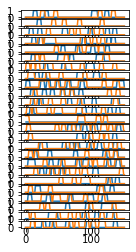

In [169]:
for index, parent_seq_id in enumerate(parent_seq_ids):   
    
    plt.subplot(len(parent_seq_ids), 1, index+1)
    WT_pwms('GFP',6, parent_seq_id, False)
    
#plt.savefig("output_figures/FigS1_A_top.pdf", dpi=300)

### RFP strand (bottom, 5'-3')

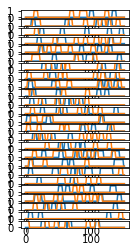

In [173]:
for index, parent_seq_id in enumerate(parent_seq_ids):   
    plt.subplot(len(parent_seq_ids), 1, index+1)
    WT_pwms('RFP',6,parent_seq_id,False)
    
#plt.savefig('output_figures/FigS1_A_bottom.pdf')

### S1B) Number of -10 and -35 boxes

Average -10 count: 5.32.
Average -35 count: 7.04.
266
352


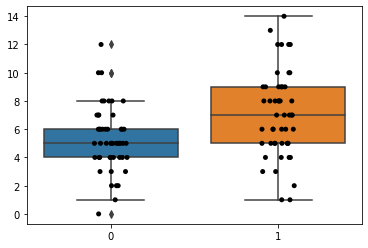

In [399]:
fluors = ['GFP', 'RFP']

ten_counts = []
thirtyfive_counts = []

for Fluor in fluors:
    for ID in parent_seq_ids:
        parent = parents_dict[ID]
        dict_10_35 = wild_type_boxes(Fluor, 6, parent)

        ten_counts.append(len(dict_10_35['minus10']))
        thirtyfive_counts.append(len(dict_10_35['minus35']))
        
data = [ten_counts, thirtyfive_counts]
sns.boxplot(data=data)
sns.stripplot(data=data, color='black')
#plt.savefig("output_figures/FigS1B.pdf")

print(f'Average -10 count: {np.mean(ten_counts)}.')
print(f'Average -35 count: {np.mean(thirtyfive_counts)}.')

print(np.sum(ten_counts))
print(np.sum(thirtyfive_counts))

### S1C) AT-content of the 25 template sequences

Text(0.5, 1.0, 'AT-content for template sequences')

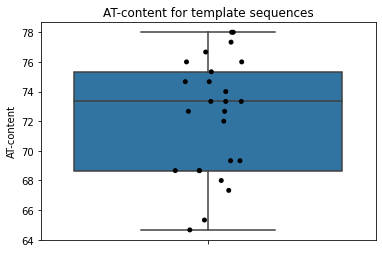

In [488]:
from Bio.SeqUtils import GC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

AT_contents = []
for ID in parent_seq_ids:
    gc_content = GC(parents_dict[ID])
    
    AT_contents.append(100-gc_content)
    
#print(AT_contents)

sns.boxplot(y=AT_contents)
sns.stripplot(y=AT_contents, color='black', jitter=True)
plt.ylabel('AT-content')
plt.title('AT-content for template sequences')

#print(np.mean(AT_contents))
#plt.savefig('output_figures/FigS1_C.pdf')

## Figure S2) Mutagenesis library and sort-seq bins

### S2A) Daughter sequences per template sequence

Text(0.5, 1.0, 'Daughter sequences')

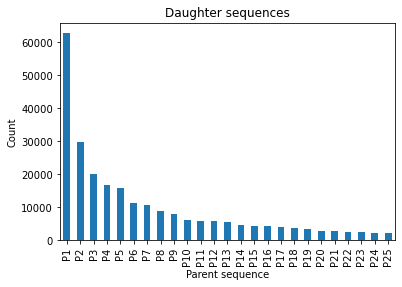

In [362]:
# Use value_counts to count the occurrences of each label
label_counts = df['matched_pi'].value_counts()

# Create a bar plot
label_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Parent sequence')
plt.ylabel('Count')
plt.title('Daughter sequences')

# Save if you want
#plt.savefig('output_figures/FigS2_A.pdf')

### S2B) Number of point mutations per daughter sequence

{0: 25, 1: 9934, 2: 147195, 3: 57650, 4: 20422, 5: 7262, 6: 2259, 7: 681, 8: 168, 9: 41, 10: 2}


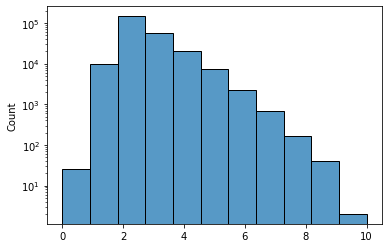

In [188]:
# The number of mutations each duaghter sequence has as a list
muts = df['distance'].to_list()

# The plot function
sns.histplot(muts, bins=11, log_scale=(False, True))
#plt.savefig('output_figures/Fig_S2_B.pdf')

# Get the counts:
count_dictionary = {}
mutations = range(0,11)
for i in mutations:
    i_count = 0
    for mut in muts:
        if mut == i:
            i_count +=1
            
    count_dictionary[i] = i_count
print(count_dictionary)

### S2C-D RFP and GFP bins and controls

<AxesSubplot:ylabel='Count'>

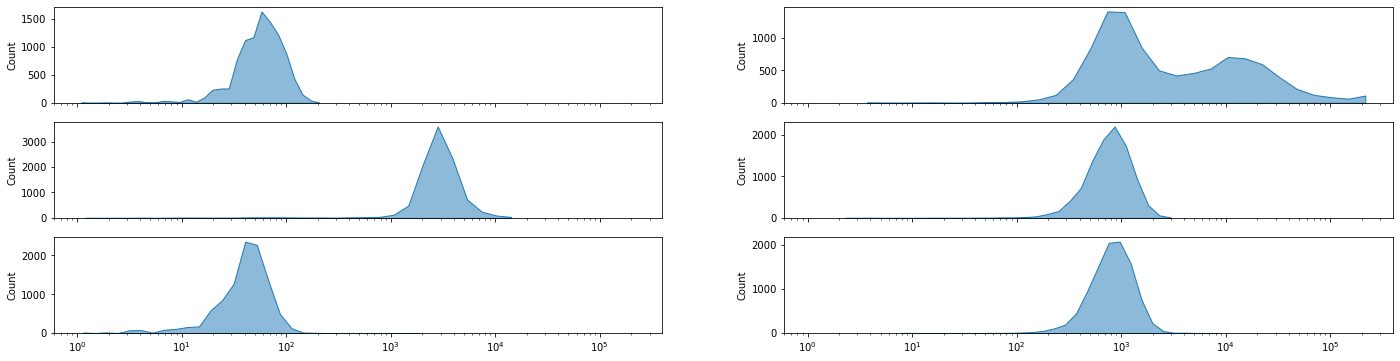

In [190]:
import FlowCal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Open the GFP+ sample (this is the sample name)
gfp = FlowCal.io.FCSData('GFP.fcs')

GFP_sample_GFP = gfp[:, ['FITC-H']]
GFP_sample_GFP = GFP_sample_GFP +1 # Otherwise the log scaling doesn't work...

GFP_sample_RFP = gfp[:, ['PE-H']]
GFP_sample_RFP = GFP_sample_RFP +1 # Otherwise the log scaling doesn't work...


# Open the RFP+ sample (this is the sample name)
rfp = FlowCal.io.FCSData('RFP.fcs')
RFP_sample_RFP = rfp[:, ['PE-H']]
RFP_sample_RFP = RFP_sample_RFP +1

RFP_sample_GFP = rfp[:, ['FITC-H']]
RFP_sample_GFP = RFP_sample_GFP +1


# Open the negative control sample
neg = FlowCal.io.FCSData('empty.fcs')

neg_sample_GFP = neg[:, ['FITC-H']]
neg_sample_GFP = neg_sample_GFP +1

neg_sample_RFP = neg[:, ['PE-H']]
neg_sample_RFP = neg_sample_RFP +1

# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24,6), sharex=True)

### The left subplot is RFP (PE-H)
# The GFP positive control
sns.histplot(GFP_sample_RFP, bins=30, element='poly', log_scale=True, ax=axes[0,0], legend=False, alpha=0.5)

# The RFP positive control
sns.histplot(RFP_sample_RFP, bins=30, element='poly', log_scale=True, ax=axes[1,0], legend=False, alpha=0.5)

# The negative control
sns.histplot(neg_sample_RFP, bins=30, element='poly', log_scale=True, ax=axes[2,0], legend=False, alpha=0.5)

### The right subplot is GFP (FITC-H)
# The GFP positive control
sns.histplot(GFP_sample_GFP, bins=30, element='poly', log_scale=True, ax=axes[0,1], legend=False, alpha=0.5)

# The RFP positive control
sns.histplot(RFP_sample_GFP, bins=30, element='poly', log_scale=True, ax=axes[1,1], legend=False, alpha=0.5)

# The negative control
sns.histplot(neg_sample_GFP, bins=30, element='poly', log_scale=True, ax=axes[2,1], legend=False, alpha=0.5)

# Save
#plt.savefig('output_figures/FigS2_CD.pdf')

## Figure S3) Mutational converage for the template sequences

### S3A) Heatmaps

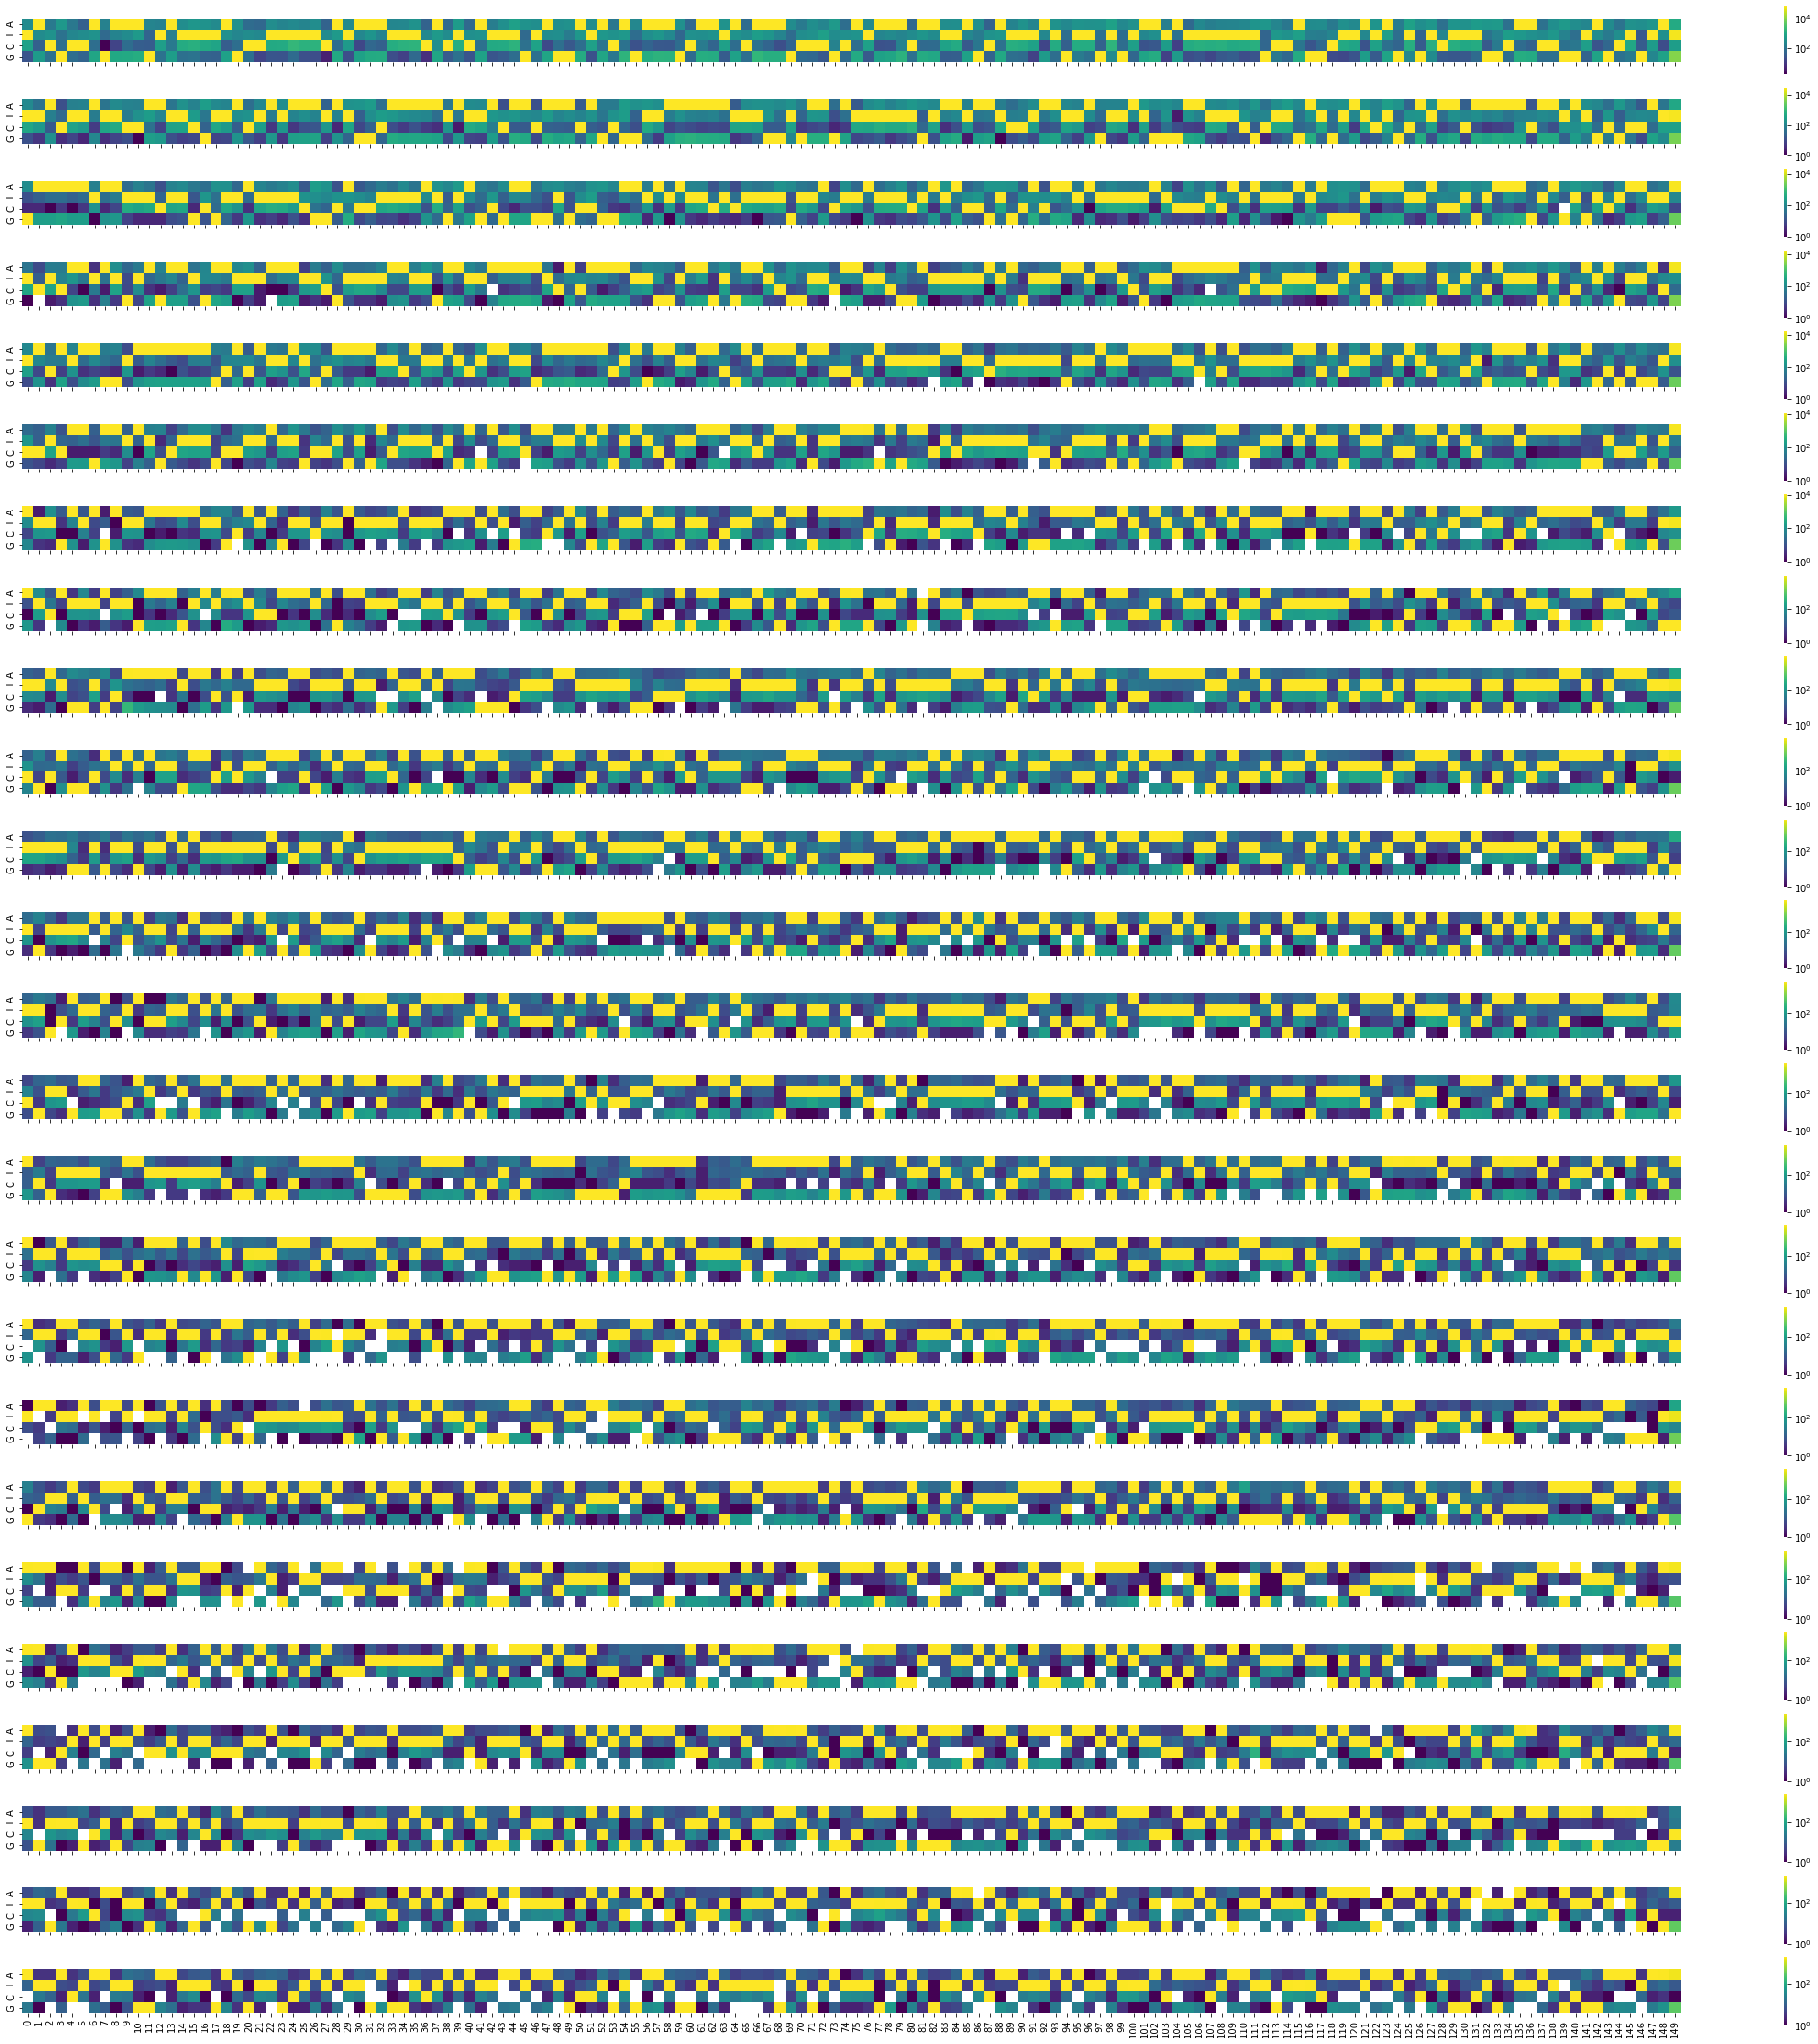

In [192]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(25, 1, figsize=(40, 40), sharex=True)

coverages = []
for index, parent in enumerate(parent_seq_ids):
    
    WT = parents_dict[parent]
    
    # Look only at daughters from the parent
    sub_df = df.drop(df[(df.matched_pi != parent)].index)
    
    # Convert daughter sequences to a list
    daughter_sequences = sub_df['seq'].to_list()
    #print(len(daughter_sequences))
    
    # i_list will be appended to this
    df_list = []

    # Loop through the daughter sequences
    for i in range(0,150):
        
        A_count = 0
        T_count = 0
        C_count = 0
        G_count = 0
        
        for daughter in daughter_sequences:
            
            if daughter[i] == 'A':
                A_count +=1
            elif daughter[i] == 'T':
                T_count +=1
            elif daughter[i] == 'C':
                C_count +=1
            elif daughter[i] == 'G':
                G_count +=1
                
        # Turn the count for A,T,C, and G at index (i) into a list
        i_list = [A_count, T_count, C_count, G_count]
        
        # Append to df_list
        df_list.append(i_list)
       
    # Create a dataframe
    parent_df = pd.DataFrame(df_list)
    
    # Rename columns
    new_column_names = ['A', 'T', 'C', 'G']
    parent_df.columns = new_column_names
    
    # How many mutations are missing?
    missing_count = 0
    for i, row in parent_df.iterrows():
        for base in new_column_names:
            if row[base] == 0:
                missing_count +=1
    #print(f'{parent}: {missing_count}/450')
    coverage = (450-missing_count) / 450
    coverages.append(coverage)
    
    # Transpose
    parent_df = parent_df.T

    # Plot
    #sns.heatmap(parent_df, norm=LogNorm(), square=True, cmap='viridis', cbar_kws={'shrink': 0.5}, ax=axes[index])
    sns.heatmap(parent_df, norm=LogNorm(), square=True, cmap='viridis', ax=axes[index])        

#plt.savefig('output_figures/FigS3_A.pdf') 

### S3B) Coverage boxplot

0.8022222222222222
0.9422222222222222
0.9304888888888888


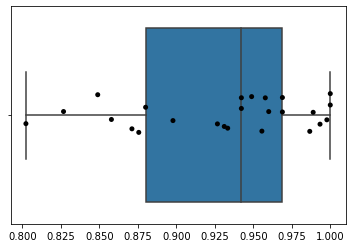

In [196]:
sns.boxplot(x=coverages)
sns.stripplot(x=coverages, color='black', jitter=True)
print(np.min(coverages))
print(np.median(coverages))
print(np.mean(coverages))
#plt.savefig('output_figures/Fig_S3B.pdf')

## Figure S4) Histogram of the fluorescence score distributions for each parent and its respective daughter sequences

### S4A)

### GFP strands

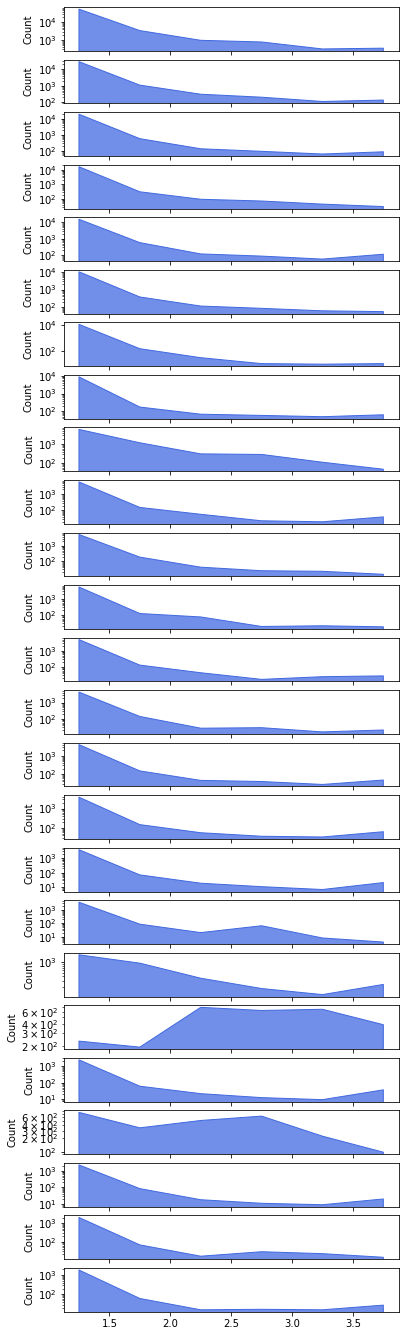

In [200]:
# Set up the subplots
fig, axes = plt.subplots(nrows=len(parent_seq_ids), ncols=1, figsize=(6,24), sharex=True)

for i, parent in enumerate(parent_seq_ids):
    
    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]
    scores = sub_df['GFP_mean'].to_list()
    #scores = [np.round(n) for n in scores]
    
    # Distplot for data1
    sns.histplot(x=scores, kde=False, ax=axes[i], binwidth=0.50, color='royalblue', element='poly')
    # Set y-axis to log scale
    axes[i].set_yscale('log')

#plt.savefig('output_figures/S4_topstrand.pdf')

### RFP strands

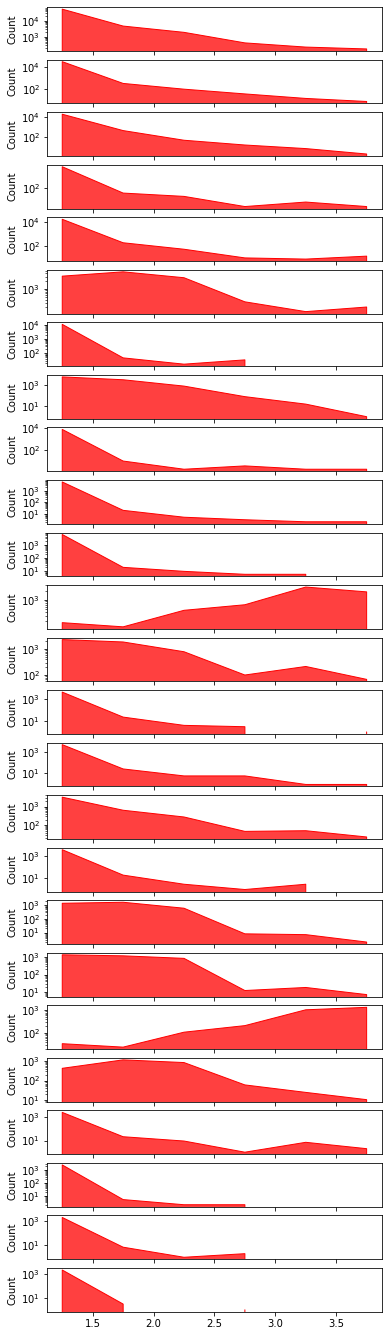

In [202]:
# Set up the subplots
fig, axes = plt.subplots(nrows=len(parent_seq_ids), ncols=1, figsize=(6,24), sharex=True)

for i, parent in enumerate(parent_seq_ids):
    
    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]
    scores = sub_df['RFP_mean'].to_list()
    #scores = [np.round(n) for n in scores]
    
    # Distplot for data1
    sns.histplot(x=scores, kde=False, ax=axes[i], binwidth=0.50, color='red', element='poly')
    # Set y-axis to log scale
    axes[i].set_yscale('log')

#plt.savefig('output_figures/S4_bottomstrand.pdf')

### S4B) Wild-type template GFP and RFP fluorescence

Text(0.5, 1.0, 'Scatterplot with Error Bars')

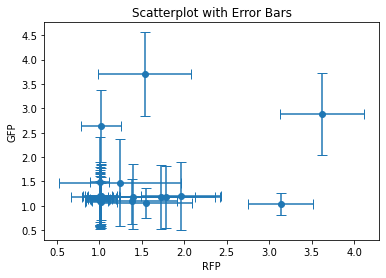

In [205]:
import matplotlib.pyplot as plt

sub_df = df.drop(df[(df.distance != 0)].index)

# Create the scatterplot with error bars
plt.errorbar(sub_df['RFP_mean'], sub_df['GFP_mean'], 
             xerr=sub_df['RFP_std'], yerr=sub_df['GFP_std'], 
             fmt='o', capsize=5)

# Add labels and title
plt.xlabel('RFP')
plt.ylabel('GFP')
plt.title('Scatterplot with Error Bars')

# Show the plot
#plt.savefig("parents_with_errors.pdf")

## Figure S5) Correlation of Pnew with sequence composition

### S5A) Pnew vs daughter count

0.5289101095900208
R-squared: 0.010516186357615535


<AxesSubplot:>

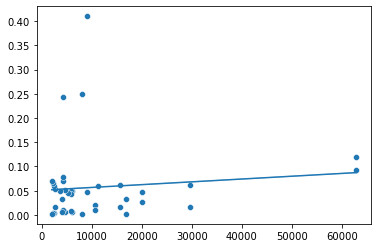

In [211]:
x = []
y = []

for Fluor in fluors:
    for parent in parent_seq_ids:
        
        if Fluor == 'GFP':
            if parent in GFP_active:
                pass
            else:
                x.append(label_counts_dict[parent])
                y.append(GFP_pnew_dict[parent])
        
        elif Fluor == 'RFP':
            if parent in RFP_active:
                pass
            else:
                x.append(label_counts_dict[parent])
                y.append(RFP_pnew_dict[parent])
                
sns.scatterplot(x=x,y=y)

x = np.array(x)
y = np.array(y)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
#print(slope)
#print(intercept)
#print(r_value)
print(p_value)
#print(std_err)

# Calculate predicted y values
y_pred = (slope * x) + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print("R-squared:", r_squared)
sns.lineplot(x=x, y=y_pred)
#plt.savefig('output_figures/Fig_S5_B.pdf')

### S5B) Pnew vs GC-content

{'P1': 34.666666666666664, 'P2': 28.0, 'P3': 31.333333333333332, 'P4': 26.0, 'P5': 24.0, 'P6': 30.666666666666668, 'P7': 22.0, 'P8': 26.666666666666668, 'P9': 23.333333333333332, 'P10': 32.666666666666664, 'P11': 22.666666666666668, 'P12': 25.333333333333332, 'P13': 31.333333333333332, 'P14': 27.333333333333332, 'P15': 35.333333333333336, 'P16': 25.333333333333332, 'P17': 22.0, 'P18': 27.333333333333332, 'P19': 26.666666666666668, 'P20': 31.333333333333332, 'P21': 32.0, 'P22': 26.666666666666668, 'P23': 30.666666666666668, 'P24': 24.666666666666668, 'P25': 24.0}
0.9298066603689544
R-squared: 0.00020688048703628332


<AxesSubplot:>

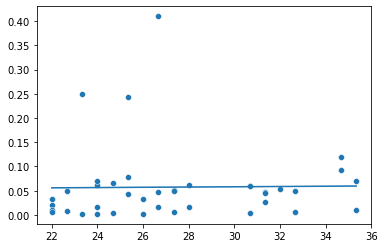

In [212]:
from Bio.SeqUtils import GC

GC_contents = {}
for ID in parent_seq_ids:
    gc_content = GC(parents_dict[ID])
    GC_contents[ID] = gc_content
    
print(GC_contents)

x = []
y = []

for Fluor in fluors:
    for parent in parent_seq_ids:
        
        if Fluor == 'GFP':
            if parent in GFP_active:
                pass
            else:
                x.append(GC_contents[parent])
                y.append(GFP_pnew_dict[parent])
        
        elif Fluor == 'RFP':
            if parent in RFP_active:
                pass
            else:
                x.append(GC_contents[parent])
                y.append(RFP_pnew_dict[parent])
                
sns.scatterplot(x=x,y=y)

x = np.array(x)
y = np.array(y)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
#print(slope)
#print(intercept)
#print(r_value)
print(p_value)
#print(std_err)

# Calculate predicted y values
y_pred = (slope * x) + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print("R-squared:", r_squared)
sns.lineplot(x=x, y=y_pred)
#plt.savefig('output_figures/Fig_S5_C.pdf')

### S5C-H) Pnew vs K-mers

possible k-mers: 5460
k-mers present 3 or more times in at least one non-promoter parent: 718
significant k-mers: ['CTTC', 'GTTG', 'ACTTC', 'GTTGA', 'AACTTC', 'TAACTT']
R-squared for CTTC: 0.29328234563997213
R-squared for GTTG: 0.32502403631915366
R-squared for ACTTC: 0.44129006520397784
R-squared for GTTGA: 0.3216543031670653
R-squared for AACTTC: 0.44129006520397784
R-squared for TAACTT: 0.3669428479384088


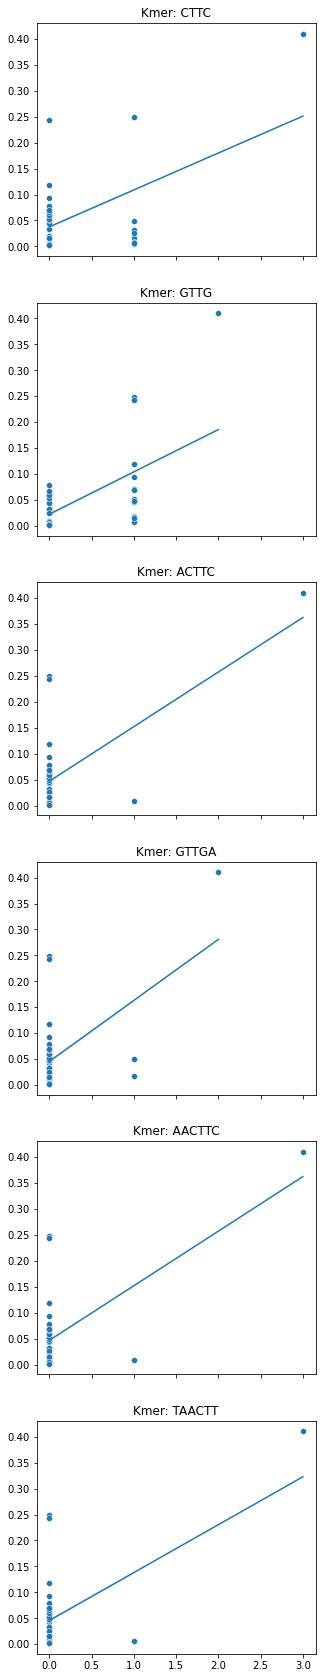

In [381]:
import itertools
import numpy as np
from scipy.stats import linregress
import statsmodels.stats.multitest as smm

fluors = ['GFP', 'RFP']

def generate_dna_sequences(length):
    """Generate all possible DNA sequences of a given length."""
    if length <= 0:
        return []
    
    nucleotides = ['A', 'C', 'G', 'T']
    sequences = [''.join(seq) for seq in itertools.product(nucleotides, repeat=length)]
    return sequences

# Look up to hexamers, otherwise space becomes too large...
all_kmers = []
for n in range(6):
    length = n+1
    combinations = generate_dna_sequences(length)
    all_kmers = all_kmers + combinations
print(f'possible k-mers: {len(all_kmers)}')

r_values = []
p_values = []
tested_kmers = []
# Loop through all kmers
for kmer in all_kmers:
    #print(kmer)
    
    x = []
    y = []
    
    for Fluor in fluors:
        for parent in parent_seq_ids:

            if Fluor == 'GFP':
                if parent in GFP_active:
                    pass
                else:

                    parent_sequence = parents_dict[parent]
                    kmer_count = parent_sequence.count(kmer)

                    x.append(kmer_count)
                    y.append(GFP_pnew_dict[parent])

            elif Fluor == 'RFP':
                if parent in RFP_active:
                    pass
                else:
                    parent_sequence = parents_dict[parent]
                    parent_sequence = str(Seq(parent_sequence).reverse_complement())
                    kmer_count = parent_sequence.count(kmer)

                    x.append(kmer_count)
                    y.append(RFP_pnew_dict[parent])

    x = np.array(x)
    y = np.array(y)

    ### Perform linear regression
    # cannot perform linear regression if all values the same...
    if len(set(x)) <= 2 or len(set(y)) <= 2:
        pass
    else:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
        # append to list
        r_values.append(r_value)
        p_values.append(p_value)
        tested_kmers.append(kmer)

print(f'k-mers present 3 or more times in at least one non-promoter parent: {len(tested_kmers)}')

        
# Create pandas df
data = {
    'kmer': tested_kmers,
    'p_value': p_values,
    'r_value': r_values
}

kmer_df = pd.DataFrame(data)


# Perform Benjamini-Hochberg correction
alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
kmer_df['Q-value'] = q_values
kmer_df['status'] = reject

# Make a list of candidate K-mers
candidate_kmers = []
for n, row in kmer_df.iterrows():
    if row['status'] == True:
        candidate_kmers.append(row['kmer'])
        #print(row['r_value']**2)
print(f'significant k-mers: {candidate_kmers}')


# Create the subplot
fig, axs = plt.subplots(len(candidate_kmers), 1, figsize=(5, 5*len(candidate_kmers)), sharex=True)


# Loop through all kmers
for i, kmer in enumerate(candidate_kmers):

    x = []
    y = []
    
    for Fluor in fluors:
        for parent in parent_seq_ids:

            if Fluor == 'GFP':
                if parent in GFP_active:
                    pass
                else:

                    parent_sequence = parents_dict[parent]
                    kmer_count = parent_sequence.count(kmer)

                    x.append(kmer_count)
                    y.append(GFP_pnew_dict[parent])

            elif Fluor == 'RFP':
                if parent in RFP_active:
                    pass
                
                else:

                    parent_sequence = parents_dict[parent]
                    parent_sequence = str(Seq(parent_sequence).reverse_complement())
                    kmer_count = parent_sequence.count(kmer)

                    x.append(kmer_count)
                    y.append(RFP_pnew_dict[parent])
                    
    x = np.array(x)
    y = np.array(y)
    
    ax = axs[i]
    ax.set_title(f'Kmer: {kmer}')
    sns.scatterplot(x=x, y=y, ax=ax)
    
    # Calculate predicted y values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_pred = (slope * x) + intercept
    r_squared = r_value ** 2
    print(f"R-squared for {kmer}: {r_squared}")
    sns.lineplot(x=x, y=y_pred, ax=ax)
    
    #plt.savefig('K-mer_correlations.pdf')

## Figure S6) Mutual information and promoter motifs in the parent sequences

In [ ]:
fluors = ['GFP','RFP']
blur = 1

for ID in parent_seq_ids:
    print(ID)
    
    for Fluor in fluors:
        print(Fluor)
        
        # Determine whether the lineplot is red or blue
        if Fluor == 'RFP':
            farbe = 'red'
        elif Fluor == 'GFP':
            farbe = 'blue'

        # ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
        means, std_devs = calculate_mutual_information(ID, Fluor, blur)
               
        # Plot individual...
        x_values = range(len(means))

        # Create a 2-row, 1-column subplot and select the top box
        fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
        top_ax = axes[0]

        # Customize x-axis ticks and annotations (every 10 units)
        top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
        top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

        # Create the Seaborn line plot for means in the top subplot
        sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

        # Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
        top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                         [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

        top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

        # The y-limit
        top_ax.set_ylim([0, 1.5*np.max(means)])

        # Plot the -10 and -35 boxes
        bot_ax = axes[1]
        WT_pwms(Fluor,window_size,ID,False)

        # Adjust subplot layout
        plt.tight_layout()

        # Save
        plt.savefig(f'output_figures/mutual_information/mut_info_pwms_{ID}-{Fluor}.pdf')

## Figure S8) Additional examples of which gaining -10 and -35 boxes creates de-novo promoters.

### S8B) Gain -10 box 14 bp downstream -35 box

-0.8303030303030303
7950
13
TTTAAT
TATAAT
0.1145875
9.287015
q=0.0007142851092968


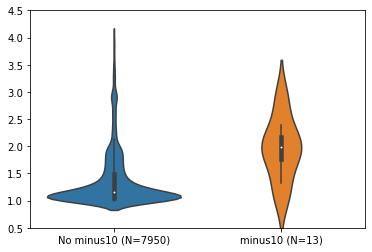

In [497]:
### KWARGS
orientation = 'top'
ID = "P9"
Fluor = 'GFP'
TF = 'minus10'
window = [136,142]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

output_df = pd.read_csv("Data_S4.csv")

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')
        
#plt.savefig('output_figures/Fig3_C.pdf')

### S8B prime) 

fluorescence increases 13.424209881946034-fold
2803.086649
2923.280423
2995.116117

45164.09913
22719.8364
57916.56847


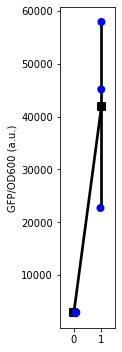

In [117]:
plot_plate_reader('P9','S8B','GFP')

### S8D) Gain -10 box 21-26 bp downstream two -35 boxes

-0.7787878787878788
62450
367
AAATTT
TAATTT
0
5.350676
q=4.4062713187785044e-110


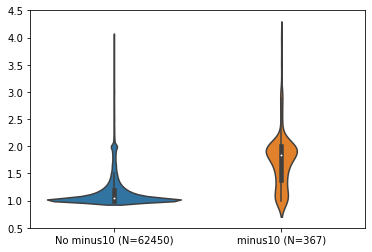

In [499]:
### KWARGS
orientation = 'bottom'
ID = "P1"
Fluor = 'RFP'
TF = 'minus10'
window = [114,120]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

fluorescence increases 1.5669624771394661-fold
3698.591812
2259.036145
2548.749261

6964.888934
7249.311836
7621.350365


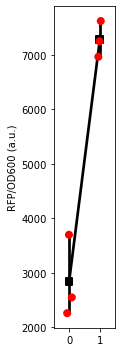

In [118]:
plot_plate_reader('P1','S8D','RFP')

### S8F) Gain extended -10 box 22-23 bp downstream two -35 boxes on the reporter plasmid

-1.7529434940547017
7541
422
AAAAAT
GAAAAT
0
4.676902
q=2.825317654583983e-173


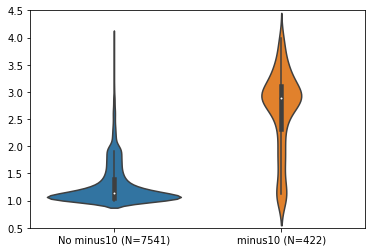

In [501]:
### KWARGS (feel free to change if you want to look at other examples)
orientation = 'top'
ID = "P9"
Fluor = 'GFP'
TF = 'minus10'
window = [9, 15]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S8F prime)

fluorescence decreases 0.012277582779958258-fold
2803.086649
2923.280423
2995.116117

2751.83855
2842.14696
3021.71767


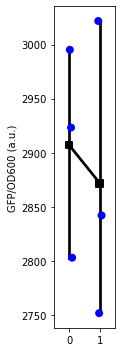

In [120]:
plot_plate_reader('P9','S8F','GFP')

### S8H) Gain -35 box 17 bp upstream -10 box

-0.5
19915
67
TAGAAA
TTGAAA
0
8.831955
q=1.0090746264778197e-29


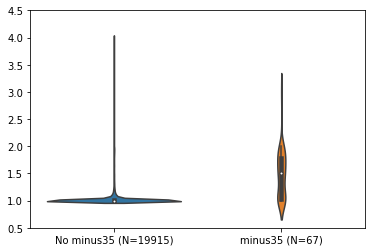

In [503]:
### KWARGS
orientation = 'bottom'
ID = "P3"
Fluor = 'RFP'
TF = 'minus35'
window = [67,73]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S8H prime)

fluorescence increases 4.039277117255614-fold
709.7128224
680.3930744
798.9447899

4355.527862
3408.800438
3266.904734


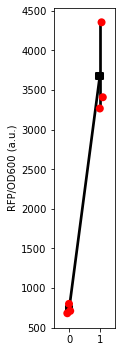

In [121]:
plot_plate_reader('P3','S8H','RFP')

### S8J) Gain -10 independent of an upstream -35 box

-0.6410640082428718
8944
18
TGAATT
TAAATT
0
6.5031385
q=7.503168331389523e-07


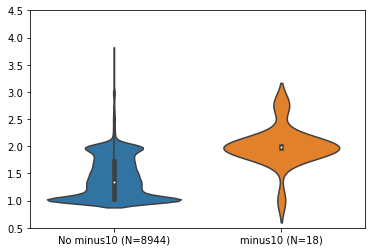

In [505]:
### KWARGS
orientation = 'bottom'
ID = "P8"
Fluor = 'RFP'
TF = 'minus10'
window = [104,110]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S8J prime)

fluorescence increases 0.2608848343476108-fold
7223.503367
9260.958206
10143.98779

16074.32721
10211.38796
7289.692794


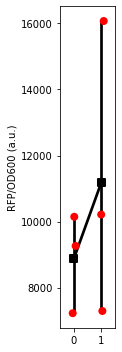

In [122]:
plot_plate_reader('P8','S8J','RFP')

### S8K) Gain -35 box 14-17 bp upstream of two -10 boxes

-0.9081391161187431
8854
108
TTAGAA
TTGGAA
0.46927577
4.260932
q=1.650960579507124e-31


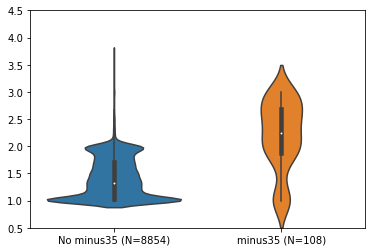

In [508]:
### KWARGS
orientation = 'bottom'
ID = "P8"
Fluor = 'RFP'
TF = 'minus35'
window = [108,114]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S8K prime)

fluorescence increases 1.8347938072161034-fold
7223.503367
9260.958206
10143.98779

23440.981
24326.11019
27719.07216


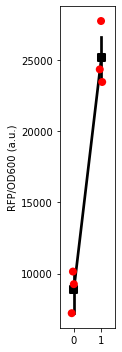

In [123]:
plot_plate_reader('P8','S8K','RFP')

### S8L) Gain -35 box 14-17 bp upstream of two -10 boxes

-0.800325545611662
8946
16
TAGAAT
TTGAAT
0
7.9351964
q=1.2935865992190773e-08


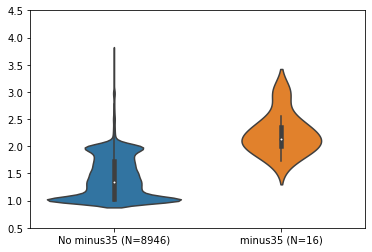

In [510]:
### KWARGS
orientation = 'bottom'
ID = "P8"
Fluor = 'RFP'
TF = 'minus35'
window = [109,115]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S8L prime)

fluorescence increases 3.139667603896143-fold
7223.503367
9260.958206
10143.98779

29309.96001
42212.86628
38710.10288


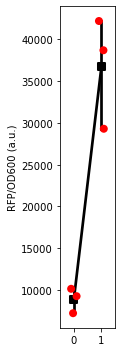

In [124]:
plot_plate_reader('P8','S8L','RFP')

## Figure S9) Mapping promoters in active parents

### S9B Destroy -10 boxes lowers expression

-0.5695652173913042
930
10213
GATACT
GATACT
4.149148
4.149148
q=8.699218866967126e-26


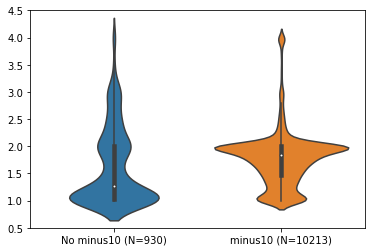

In [512]:
### KWARGS
orientation = 'bottom'
ID = "P6"
Fluor = 'RFP'
TF = 'minus10'
window = [92,98]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

-0.7333333333333332
934
10209
TACTAT
TACTAT
5.793827
5.793827
q=8.208146986668407e-70


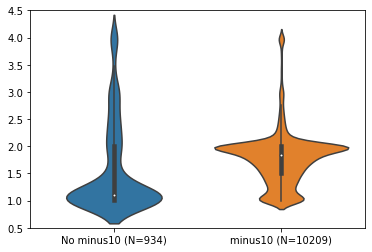

In [513]:
### KWARGS
orientation = 'bottom'
ID = "P6"
Fluor = 'RFP'
TF = 'minus10'
window = [94,100]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

-0.8211686718350475
588
10555
TATAAT
TATAAT
9.287015
9.287015
q=2.956712588697641e-229


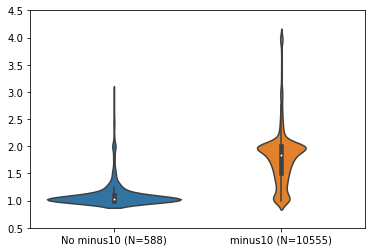

In [514]:
### KWARGS
orientation = 'bottom'
ID = "P6"
Fluor = 'RFP'
TF = 'minus10'
window = [97,103]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S9B prime)

fluorescence decreases 10.393118597855418-fold
5439.170758
8185.207151
6151.642646

458.0466263
689.5045006
588.2352941


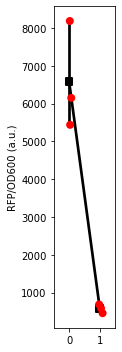

In [125]:
plot_plate_reader('P6','S9B','RFP')

### S9D) Destroy -35 lowers expression

-1.5729274797533037
152
5738
TNGACA
TTGACA
0
8.39025
q=6.283468612923347e-67


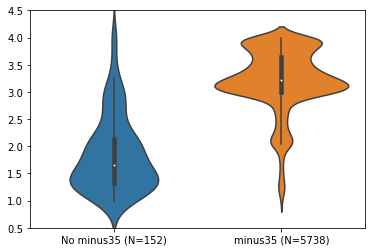

In [516]:
### KWARGS
orientation = 'bottom'
ID = "P12"
Fluor = 'RFP'
TF = 'minus35'
window = [110,116]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S9D prime)

fluorescence decreases 62.57226263250689-fold
36019.98017
34376.15894
35009.73339

615.5993177
475.6472137
566.8016194


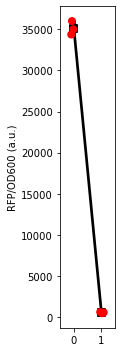

In [126]:
plot_plate_reader('P12','S9D','RFP')

### S9E) Destroy -10 lowers expression

-1.4114159155242543
198
5692
TACRAT
TACAAT
0
6.9462895
q=6.276541741951467e-91


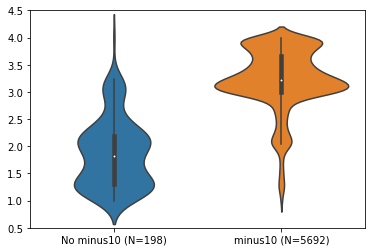

In [518]:
### KWARGS
orientation = 'bottom'
ID = "P12"
Fluor = 'RFP'
TF = 'minus10'
window = [134,140]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S9E prime)

fluorescence decreases 49.736517179602-fold
36019.98017
34376.15894
35009.73339

630.7067974
645.3387832
801.4693605


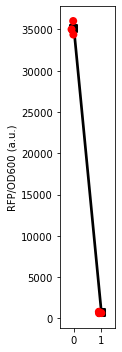

In [127]:
plot_plate_reader('P12','S9E','RFP')

### S9G) Destroy -10/35 boxes lowers expression

-0.713461603705642
544
4781
TTTACA
TTTACA
5.7440243
5.7440243
q=6.726491112714389e-155


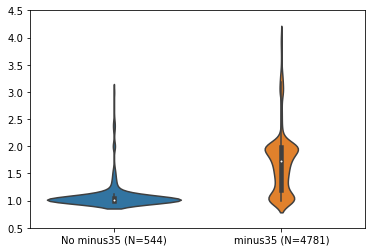

In [520]:
### KWARGS
orientation = 'bottom'
ID = "P13"
Fluor = 'RFP'
TF = 'minus35'
window = [111,117]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

-0.6636326779515633
414
4911
TACATT
TACATT
4.9024944
4.9024944
q=2.517992033856248e-74


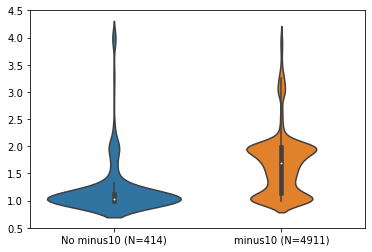

In [521]:
### KWARGS
orientation = 'bottom'
ID = "P13"
Fluor = 'RFP'
TF = 'minus10'
window = [113,119]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S9G prime)

fluorescence decreases 8.27066004619426-fold
3082.604635
3715.856096
3972.661995

346.6758883
406.885759
408.2890378


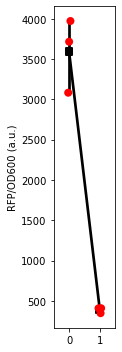

In [130]:
plot_plate_reader('P13','S9G35','RFP')

### S9G double prime)

fluorescence increases 10.20128284452369-fold
296.6765269
438.6369933
226.283725

3082.604635
3715.856096
3972.661995


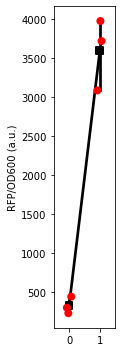

In [131]:
plot_plate_reader('S9G10','P13','RFP')

### S9I) Destroy -35 box lowers expression

-0.88871473354232
279
2283
TYGTTT
TTGTTT
0
4.5858684
q=7.191824804149176e-35


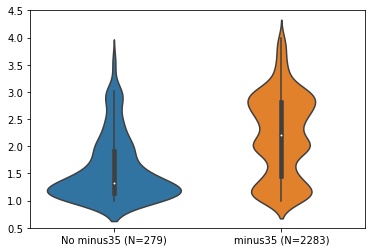

In [524]:
### KWARGS
orientation = 'top'
ID = "P22"
Fluor = 'GFP'
TF = 'minus35'
window = [110,116]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S9I prime)

fluorescence decreases 1.5389067548566593-fold
44585.56514
48335.19657
30595.43364

4400.587321
39738.63879
4510.136499


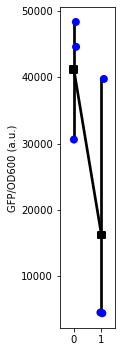

In [132]:
plot_plate_reader('P22','S9I35','GFP')

### S9I double prime)

fluorescence decreases 13.388242148358515-fold
44585.56514
48335.19657
30595.43364

2921.414394
2798.12505
2864.983535


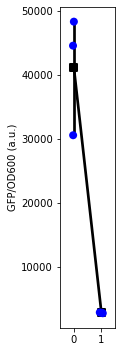

In [133]:
plot_plate_reader('P22','S9I10','GFP')

## Figure S10) Additional examples of mutations modulating promoter activity

### S10A) P19-GFP homo-gain -10 box

-0.9504079990805658
3445
11
CACTAT
TACTAT
0
5.793827
q=0.0020280645237706


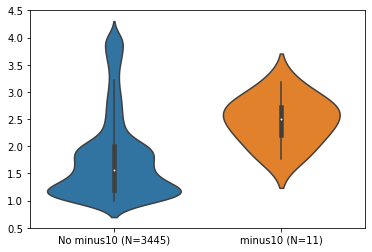

In [527]:
### KWARGS
orientation = 'top'
ID = 'P19'
Fluor = 'GFP'
TF = 'minus10'
window = [99, 105]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10A prime)

fluorescence increases 6.1466898356660495-fold
5317.76263
5751.151087
5949.704142

44085.35521
34161.23141
43380.19665


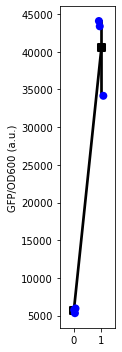

In [134]:
plot_plate_reader('P19','S10A','GFP')

### S10B) P13-RFP homo-gain -35 box

0.6056435450648558
5282
43
TTTTAC
TTTTAT
0.44913796
3.5566664
q=1.3983055718353162e-06


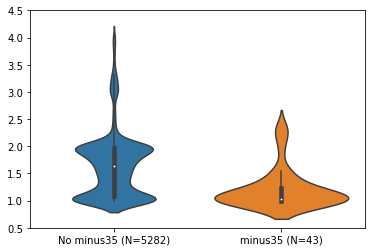

In [529]:
### KWARGS
orientation = 'bottom'
ID = 'P13'
Fluor = 'RFP'
TF = 'minus35'
window = [110, 116]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10B prime)

fluorescence decreases 11.15837521884345-fold
3082.604635
3715.856096
3972.661995

275.9697995
284.2565598
325.675131


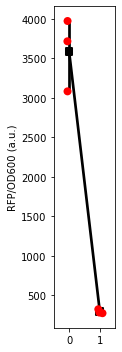

In [135]:
plot_plate_reader('P13','S10B','RFP')

### S10C) P13-RFP homo-gain -35 box

0.6205752003771805
5249
76
TTACAT
TTGCAT
3.2383995
7.0300555
q=7.788006157746863e-15


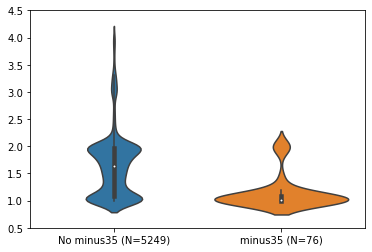

In [531]:
### KWARGS
orientation = 'bottom'
ID = 'P13'
Fluor = 'RFP'
TF = 'minus35'
window = [112, 118]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10C prime)

fluorescence decreases 4.19206927110267-fold
3082.604635
3715.856096
3972.661995

634.6214263
672.9681693
766.9441141


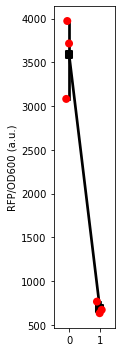

In [136]:
plot_plate_reader('P13','S10C','RFP')

### S10D) P13-RFP homo-gain -10 box

0.6095125660281551
5311
14
TATATA
TATATT
0.40275666
7.24322
q=0.0023593932176521


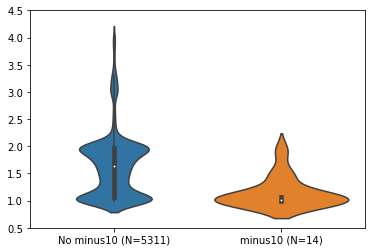

In [533]:
### KWARGS
orientation = 'bottom'
ID = 'P13'
Fluor = 'RFP'
TF = 'minus10'
window = [130, 136]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10D prime)

fluorescence decreases 3.6678222356246377-fold
3082.604635
3715.856096
3972.661995

801.5896821
868.8547883
637.0818625


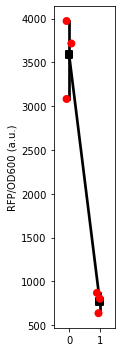

In [137]:
plot_plate_reader('P13','S10D','RFP')

### S10E) P6-RFP homo-gain -35 box

0.7859320761797539
11107
36
TTTAAC
TTTAAT
2.1814423
5.2889705
q=1.2486454467921686e-07


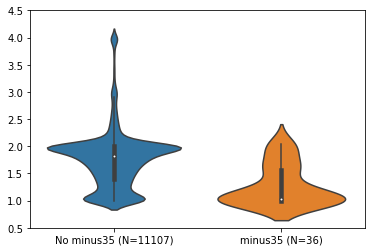

In [535]:
### KWARGS
orientation = 'bottom'
ID = 'P6'
Fluor = 'RFP'
TF = 'minus35'
window = [73, 79]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10E prime)

fluorescence decreases 0.7627854582073864-fold
5439.170758
8185.207151
6151.642646

2686.298077
4133.48738
4398.834746


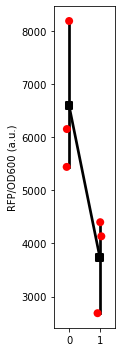

In [138]:
plot_plate_reader('P6', 'S10E', 'RFP')

### S10F) P6-RFP hetero-gain -10 box

-0.9723571968469926
11080
63
AACATT
TACATT
0
4.9024944
q=1.1946166113763849e-23


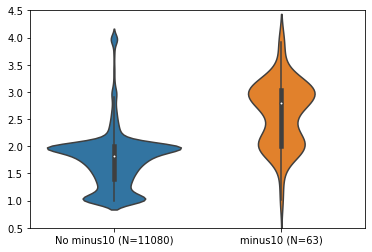

In [537]:
### KWARGS
orientation = 'bottom'
ID = 'P6'
Fluor = 'RFP'
TF = 'minus10'
window = [76, 82]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10F prime)

fluorescence increases 3.81076401520761-fold
5439.170758
8185.207151
6151.642646

31052.15908
30159.98512
33925.62385


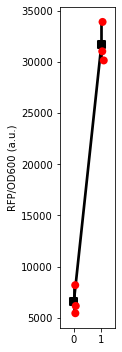

In [139]:
plot_plate_reader('P6', 'S10F', 'RFP')

### S10G) P6-RFP hetero-gain -35 box

0.8096450556127972
11099
44
TATAAT
TTTAAT
0
5.2889705
q=1.2291569311114083e-20


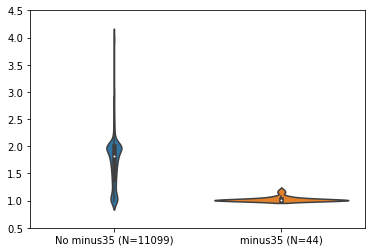

In [539]:
### KWARGS
orientation = 'bottom'
ID = 'P6'
Fluor = 'RFP'
TF = 'minus35'
window = [97, 103]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S10G prime)

fluorescence decreases 5.403016213325448-fold
5439.170758
8185.207151
6151.642646

1403.916659
891.5616648
793.0693069


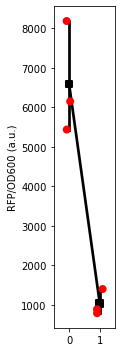

In [140]:
plot_plate_reader('P6', 'S10G', 'RFP')

## Figure S11) Template P20

### S11B) P20-GFP gain -35 box

-0.9493333333333336
2762
23
ATGATT
TTGATT
0.8765054
6.318173
q=6.297325759112813e-08


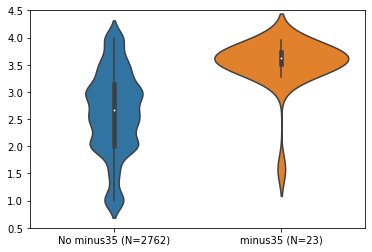

In [541]:
### KWARGS
orientation = 'top'
ID = 'P20'
Fluor = 'GFP'
TF = 'minus35'
window = [21, 27]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S11C) P20-GFP gain -10 box

-0.5700396825396825
2699
86
TACTTT
TACTCT
3.7500317
4.5259914
q=1.0809947874013086e-05


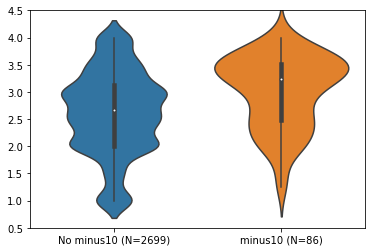

In [542]:
### KWARGS
orientation = 'top'
ID = 'P20'
Fluor = 'GFP'
TF = 'minus10'
window = [46, 52]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S11D) P20-GFP gain -35 box

0.6666666666666665
2766
19
ATAAAA
WTRAAA
0
0
q=0.0370947154105149


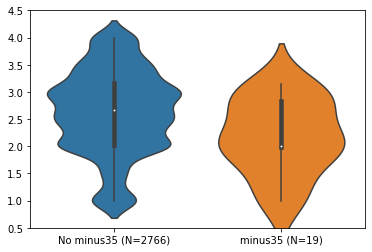

In [543]:
### KWARGS
orientation = 'top'
ID = 'P20'
Fluor = 'GFP'
TF = 'minus35'
window = [95, 101]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S11E) P20-RFP gain -10 box

0.5253211559415814
2772
13
TAATCA
TAATCT
0
6.1266356
q=0.0018794809871613


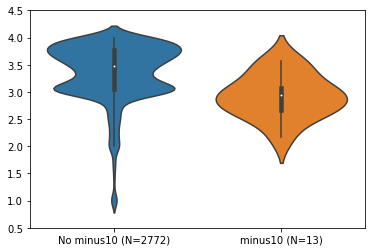

In [544]:
### KWARGS
orientation = 'bottom'
ID = 'P20'
Fluor = 'RFP'
TF = 'minus10'
window = [122, 128]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)
# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

## Figure S12) Additional H-NS sites

### S12A) H-NS modulates the bidirectional promoter in P20

T-statistic: -6.485703809597976
P-value: 1.5921387762018202e-06
fold_change: 2.6293146748507463.


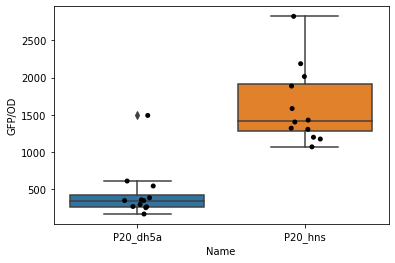

In [462]:
sub_df = hns_df[hns_df['Name'].str.contains('P20')]
sns.stripplot(data=sub_df, x='Name', y='GFP/OD', color='black')
sns.boxplot(data=sub_df, x='Name', y='GFP/OD')
#plt.savefig("P20_hns_GFP_increase.pdf")

dh5a = []
hns = []
for i, row in sub_df.iterrows():
    if 'dh5a' in row['Name']:
        dh5a.append(row['GFP/OD'])
    elif 'hns' in row['Name']:
        hns.append(row['GFP/OD'])
        
# Perform the two-tailed t-test
t_stat, p_value = stats.ttest_ind(dh5a, hns)

# Output the result
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
        
fold_change = (np.mean(hns)-np.mean(dh5a))/np.mean(dh5a)
print(f'fold_change: {fold_change}.')

T-statistic: 4.095810171059667
P-value: 0.0004774501992725452
fold_change: 0.415985725739304.


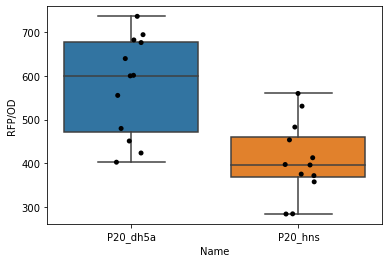

In [463]:
sub_df = hns_df[hns_df['Name'].str.contains('P20')]
sns.stripplot(data=sub_df, x='Name', y='RFP/OD', color='black')
sns.boxplot(data=sub_df, x='Name', y='RFP/OD')
plt.savefig("P20_hns_RFP_decrease.pdf")

dh5a = []
hns = []
for i, row in sub_df.iterrows():
    if 'dh5a' in row['Name']:
        dh5a.append(row['RFP/OD'])
    elif 'hns' in row['Name']:
        hns.append(row['RFP/OD'])

# Perform the two-tailed t-test
t_stat, p_value = stats.ttest_ind(dh5a, hns)

# Output the result
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
        
fold_change = (np.mean(dh5a)-np.mean(hns))/np.mean(hns)
print(f'fold_change: {fold_change}.')

### S12B) Significant median fluorescence gains from losing H-NS motifs

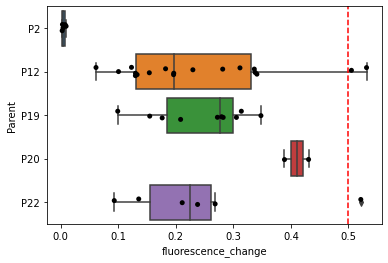

In [325]:
import statsmodels.stats.multitest as smm

output_df = pd.read_csv("hns_df.csv")

# Create sub_df, which only focuses on P12 and P21...
filtered_df = output_df.drop(output_df[~output_df['Parent'].isin(["P12", "P22", "P2", "P19", "P20"])].index)
sub_df = filtered_df[((filtered_df['Parent'] == 'P22') & (filtered_df['Fluor'] == 'GFP')) |
                     ((filtered_df['Parent'] == 'P12') & (filtered_df['Fluor'] == 'RFP')) |
                     ((filtered_df['Parent'] == 'P20') & (filtered_df['Fluor'] == 'GFP')) |
                     ((filtered_df['Parent'] == 'P2') & (filtered_df['Fluor'] == 'GFP')) |
                     ((filtered_df['Parent'] == 'P19') & (filtered_df['Fluor'] == 'GFP'))]

# Add whether it is a gain or a loss of the H-NS motif
gain_loss = []
for i, row in sub_df.iterrows():
    
    # Was the site gained or lost?
    if row['N_without'] > row['N_with']: # The site was gained
        gain_loss.append('gain')
    else: # The site was lost
        gain_loss.append('loss')

# Add column to sub_df
sub_df['gain_loss'] = gain_loss

# Only keep those where the site is lost
sub_df = sub_df[(sub_df['gain_loss'] == 'loss')]

# Calculate the fluorescence changes
changes = []
for i, row in sub_df.iterrows():
    fluorescence_change = row['Fluor_without'] - row['Fluor_with']
    changes.append(fluorescence_change)
sub_df['fluorescence_change'] = changes

# Only keep those where fluorescence increases
sub_df = sub_df[(sub_df['fluorescence_change'] > 0)]

# Perform Benjamini-Hochberg correction
p_values = sub_df['P-value'].to_list()
alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
sub_df['Q-value'] = q_values
sub_df['status'] = reject

# Only keep those where fluorescence increases
sub_df = sub_df[(sub_df['status'] == True)]

# sub_df = sub_df[((sub_df['Parent'] == 'P22') & (sub_df['Fluor'] == 'GFP')) |
#                      ((sub_df['Parent'] == 'P12') & (sub_df['Fluor'] == 'RFP'))]

# Violins and stripplots
sns.stripplot(data=sub_df, x='fluorescence_change', y='Parent', color='black')
sns.boxplot(data=sub_df, x='fluorescence_change', y='Parent')

# Add a vertical line at x = 0.5
plt.axvline(x=0.5, color='red', linestyle='--')

### S12C) Gaining a -35 box in P12-RFP appears to lower expression

1.0624857662903247
5878
12
TTTTTT
TTTWWT
1.9396427
0
q=3.346556308202744e-05


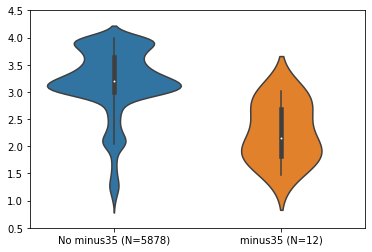

In [554]:
### KWARGS
orientation = 'bottom'
ID = "P12"
Fluor = 'RFP'
TF = 'minus35'
window = [92, 98]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

output_df = pd.read_csv("Data_S4.csv")

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S12D) Gaining a -10 box in P12-RFP appears to lower expression

0.6058807134069619
5878
12
TAAATC
TAAATT
0
6.5031385
q=0.0004359056402968


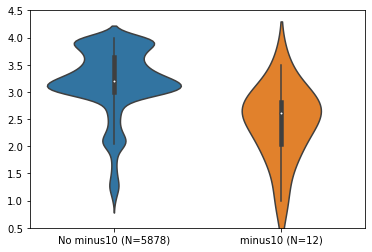

In [555]:
### KWARGS
orientation = 'bottom'
ID = "P12"
Fluor = 'RFP'
TF = 'minus10'
window = [119, 125]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Get the q-value
sub_df = output_df[((output_df['Fluor'] == Fluor) & (output_df['Parent'] == ID) & (output_df['PWM'] == TF))]
for i, row in sub_df.iterrows():
    if str(row['ROI']) == str(window):
        print(f'q={row["Q-value"]}')

### S12E-F) H-NS knockout rescues the -35 fluorescence decrease

<AxesSubplot:xlabel='Name', ylabel='RFP/OD'>

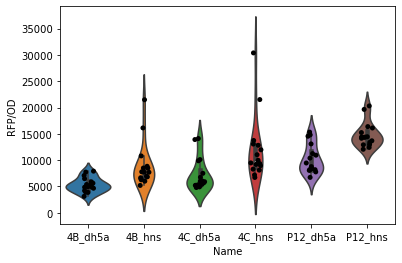

In [556]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tandem_df = pd.read_csv("4b_4c_repeat.csv")
sns.violinplot(data=tandem_df, x='Name', y='RFP/OD')
sns.stripplot(data=tandem_df, x='Name', y='RFP/OD', color='black')

In [563]:
from scipy.stats import ttest_ind
def two_tailed_t(group1, group2):
    group1_values = []
    group2_values = []
    for i, row in tandem_df.iterrows():
        if row['Name'] == group1:
            group1_values.append(row['RFP/OD'])
        if row['Name'] == group2:
            group2_values.append(row['RFP/OD'])

    t_statistic, p_value = ttest_ind(group1_values, group2_values)
    print(f'p = {p_value}')
    
group1 = 'P12_dh5a'
group2 = '4B_dh5a'
two_tailed_t(group1, group2)

group1 = '4B_dh5a'
group2 = '4B_hns'
two_tailed_t(group1, group2)

group1 = 'P12_dh5a'
group2 = '4B_hns'
two_tailed_t(group1, group2)

group1 = 'P12_dh5a'
group2 = '4C_dh5a'
two_tailed_t(group1, group2)

group1 = '4C_dh5a'
group2 = '4C_hns'
two_tailed_t(group1, group2)

group1 = 'P12_dh5a'
group2 = '4C_hns'
two_tailed_t(group1, group2)

p = 5.953413123090522e-07
p = 0.003592050803202816
p = 0.2764986524064682
p = 0.007549870441706694
p = 0.009628678820099889
p = 0.30956292350229453


## S13) The changes in fluorescence when gaining and losing UP-like motifs

(-1.0, 1.0)

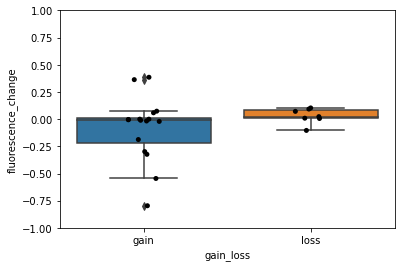

In [564]:
# Open Data_S8.csv
output_df = pd.read_csv("Data_S8.csv")

sns.boxplot(data=output_df, x='gain_loss', y='fluorescence_change')
sns.stripplot(data=output_df, x='gain_loss', y='fluorescence_change', color='black')
plt.ylim(-1,1)

# Recreate dataframes for Data S2-S6

## Data S2 (Incomplete...) - Daughter sequences and their fluorescence scores
Data S2 is a dataframe with all daughter sequences and their respective fluorescence scores after quality filtering the data as described in the Methods subsection: Processing sequencing reads. Data is stored as a csv file.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import the dataframe
df = pd.read_csv('Data_S2.csv')

# remove sequences not equal to 150 bp
df = df[df['seq'].apply(lambda x: len(x) == 150)]

# A read must occur more than 30 times between each of the bins
df = df[df['sum_occur'].apply(lambda x: x >= 30)]

# the number of mutations less than 10
df = df[df['distance'].apply(lambda x: x <= 10)]

# Calculate the fluorescence scores
GFP_mean = []
GFP_std = []
RFP_mean = []
RFP_std = []

GFP_median = []
RFP_median = []

for i, row in df.iterrows():
    
    ### GFP
    # number of 1s, 2s, 3s, and 4s for GFP
    one_list = [1] * row['sum_bin1']
    two_list = [2] * row['sum_bin2']
    three_list = [3] * row['sum_bin3']
    four_list = [4] * row['sum_bin4']
    
    # Add scores together into a list
    GFP_list = one_list + two_list + three_list + four_list
    
    # Append mean and std to list
    GFP_mean.append(np.mean(GFP_list))
    GFP_std.append(np.std(GFP_list))
    GFP_median.append(np.median(GFP_list))
    
    ### RFP
    # number of 1s, 2s, 3s, and 4s for GFP
    one_list = [1] * row['sum_bin5']
    two_list = [2] * row['sum_bin6']
    three_list = [3] * row['sum_bin7']
    four_list = [4] * row['sum_bin8']
    
    # Add scores together into a list
    RFP_list = one_list + two_list + three_list + four_list
    
    # Append mean and std to list
    RFP_mean.append(np.mean(RFP_list))
    RFP_std.append(np.std(RFP_list))
    RFP_median.append(np.median(RFP_list))
    
# Append to the dataframe
df['GFP_mean'] = GFP_mean
df['GFP_std'] = GFP_std
df['GFP_median'] = GFP_median

df['RFP_mean'] = RFP_mean
df['RFP_std'] = RFP_std
df['RFP_median'] = RFP_median

## Data S3 - Mutual information hotspots
Data S3 is a dataframe containing the location of each mutational information hotspot, and information on whether the hotspot overlaps with a -10 or -35 box. Data is stored as a csv file.

In [ ]:
import itertools

### Create the hotspot_df
# Define the columns for the dataframe
data = {
    'Hotspot_ID': [],
    'Parent': [],
    'Orientation': [],
    'Coordinate':[]
}
column_names = ['Hotspot_ID', 'Parent', 'Orientation', 'Coordinate']

# Create a DataFrame
hotspot_df = pd.DataFrame(data)

# Calculate the mutual information from each parent to find the hotspots
fluors = ['GFP','RFP']
blur = 1
window_size = 6

number = 1
for ID in parent_seq_ids:
    print(ID)
    
    for Fluor in fluors:
        print(Fluor)

        # ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
        means, std_devs = calculate_mutual_information(ID, Fluor, blur)
        
        # Get the hotspot indexes
        indexes = index_hotspots(means, std_devs)
        
        # Create a new row for the hotspot_df
        for i in indexes:
            dataframe_row = [number, ID, Fluor, i]
            print(dataframe_row)
            hotspot_df = hotspot_df.append(pd.Series(dataframe_row, index=column_names), ignore_index=True)
            number+=1
            
# Find out if each hotspot overlaps with a -10 or a -35 box
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in hotspot_df.iterrows():
    
    # Define the variables from each row
    ID = int(row['Parent'])
    Fluor = row['Orientation']
    index = int(row['Coordinate'])
    
    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'
    
    # Get the PWMs for the parent sequence (it is calculated every iteration, I know it's not efficient...)
    PWM_indexes = WT_pwms(Fluor, window_size, ID,False)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']
    
    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'
        
    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'
        
    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
hotspot_df['overlap_10_same'] = overlap_10
hotspot_df['overlap_35_same'] = overlap_35
hotspot_df['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

hotspot_df

## Data S4 - where gaining and losing -10 and -35 boxes changes fluorescence
Data S4 is a dataframe with the results from our computational search for regions where -10 and -35 boxes are gained or lost, and the extent to which they associate with significant fluorescence changes. Data stored as a csv file.  

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import itertools
import numpy as np
import statsmodels.stats.multitest as smm

### KWARGS: define the following variables:
windows = [6] # size of the sliding window
orientations = ['top','bottom']
fluors = ['GFP','RFP'] # GFP and RFP
TFs = ['minus10','minus35'] # both -10 and -35 boxes
filenames = parent_seq_ids

# Generate all possible combinations of variables from the lists
combinations = itertools.product(orientations, filenames, fluors, TFs, windows)

# Create an empty DataFrame with column names
column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]
output_df = pd.DataFrame(columns=column_names)

# # Iterate over each combination and call your function with the corresponding inputs
for combination in combinations:
    print(combination)
    
    output = PWM_fluorescence_slide_function(*combination)
    
    if output is None:
        pass
    else:
        
        for n in output: # there can be multiple outputs
            
            # Add the conditions to the row as well
            dataframe_row = list(combination) + n
            
            # Add each row to the dataframe
            row_df = pd.DataFrame([dataframe_row], columns=column_names)
            output_df = pd.concat([output_df, row_df], ignore_index=True)
    
# Perform Benjamini-Hochberg correction
p_values = output_df['P-value'].to_list()
alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
output_df['Q-value'] = q_values
output_df['status'] = reject

# only the Q-values are significant
output_df = output_df.drop(output_df[(output_df.status != True)].index)

# Drop rows with 'nan' values
output_df = output_df.dropna()

# Computer whether the motif was gained or lost and add to the dataframe
gain_loss = []
for i, row in output_df.iterrows():
    
    # number of motifs in each category
    n_without = row['N_without']
    n_with = row['N_with']
    
    if n_with > n_without:
        gain_loss.append('loss')
    elif n_with < n_without:
        gain_loss.append('gain')
output_df['gain-loss'] = gain_loss

# Calculate the median difference in expression:
differences = []
for i, row in output_df.iterrows():
    if row['gain-loss'] == 'gain':
        after = row['Fluor_with']
        before = row['Fluor_without']
    elif row['gain-loss'] == 'loss':
        before = row['Fluor_with']
        after = row['Fluor_without']
    
    difference = after-before
    
    differences.append(difference)
output_df['fluorescence_change'] = differences

# Match the output to known hotspots in Data S3
hotspot_df = pd.read_csv("Data_S3.csv")

matching_hotspot_IDs = [] # Every row in the output_df will have an entry in this list, either "None" or a "Hotspot_ID" number from the hotspot_df
# For each significant association:
for i, out_row in output_df.iterrows():
    
    hotspot_ID = 'None' # This value is appended to "matching_hotspot_IDs" at the end of the loop, and is updated if a positive match is found.
    opposite = "None"
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    
    # Get the ROI, flip if on the opposite strand, change to a set
    ROI = out_row['ROI']
    #ROI_range = eval(ROI)
    ROI_range = ROI

    if Orientation == 'top' and Fluor == 'GFP' or Orientation == 'bottom' and Fluor == 'RFP':
        opposite = False
    else:
        opposite = True
        ROI_range = [150-n for n in ROI_range]       
    ROI_set = set(ROI_range)

    # Look for a match to a hotspot in the hotspot dataframe:
    for n, row in hotspot_df.iterrows():
        
        Parent = row['Parent']
        Hot_fluor = row['Orientation']
        
        if Hot_fluor == 'GFP':
            Hot_orientation = 'top'
        elif Hot_fluor == 'RFP':
            Hot_orientation = 'bottom'
        
        # Get the index, create a range and set from it
        index = int(row['Coordinate'])
        index_range = range(index-3, index+3)
        index_set = set(index_range)
        
        # Find a match:
        if opposite == False:
            if ID == Parent and Fluor == Hot_fluor and Orientation == Hot_orientation:
            
                #intersection = ROI_set & index_set
                intersection = ROI_set.intersection(index_set)
                if len(intersection) > 0:

                    # Match found. Update the hotspot_ID
                    hotspot_ID = int(row['Hotspot_ID'])
                
        elif opposite == True:
            if ID == Parent and Fluor == Hot_fluor and Orientation != Hot_orientation:
                intersection = ROI_set.intersection(index_set)
                if len(intersection) > 0:
            
                    hotspot_ID = int(row['Hotspot_ID'])           
            
    # Append to the list whether a match was found or not            
    matching_hotspot_IDs.append(hotspot_ID)
            
# Add the hotspot ID to the dataframe
output_df['Hotspot_ID'] = matching_hotspot_IDs

# Remove values which don't match with a hotspot
output_df = output_df.drop(output_df[(output_df.Hotspot_ID == 'None')].index)

# Save the output_df
#output_df.to_csv('Data_S4.csv', index=False)

## Data S7 - Where gaining and losing H-NS motifs changes fluorescence (insert description)

In [ ]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio import motifs
import math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import itertools
import statsmodels.stats.multitest as smm

### Step 1) Import the PWM for H-NS
PSSM_txt_open = open('hns_instances.txt', 'r') # only instances from HNS
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
print("PSSMs and thresholds calculated!")

In [ ]:
### Step 2) Does gaining or losing a HNS motif associate with fluorescence changes?

# KWARGS:
windows = [12] # size of the sliding window (H-NS motif is 12 bp long, don't change this)
orientations = ['top','bottom']
fluors = ['GFP','RFP'] # GFP and RFP
TFs = ['HNS'] # HNS only
filenames = parent_seq_ids # You can make a new list with a subset of the sequences. For example: filenames = ['P22']

# Generate all possible combinations of variables from the lists
combinations = itertools.product(orientations, filenames, fluors, TFs, windows)

# Create an empty DataFrame with column names
column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]
output_df = pd.DataFrame(columns=column_names)

# # Iterate over each combination and call your function with the corresponding inputs
for combination in combinations:
    print(combination)
    
    output = PWM_fluorescence_slide_function(*combination)
    
    if output is None:
        pass
    else:
        
        for n in output: # there can be multiple outputs
            
            # Add the conditions to the row as well
            dataframe_row = list(combination) + n
            
            # Add each row to the dataframe
            row_df = pd.DataFrame([dataframe_row], columns=column_names)
            output_df = pd.concat([output_df, row_df], ignore_index=True)
    
print('done.')

In [ ]:
### Step 3) Dataframe processing...

# Create sub_df, which only focuses on P12 and P21...
filtered_df = output_df.drop(output_df[~output_df['Parent'].isin(["P12", "P22", "P2", "P19", "P20"])].index)
sub_df = filtered_df[((filtered_df['Parent'] == 'P22') & (filtered_df['Fluor'] == 'GFP')) |
                     ((filtered_df['Parent'] == 'P12') & (filtered_df['Fluor'] == 'RFP')) |
                     ((filtered_df['Parent'] == 'P20') & (filtered_df['Fluor'] == 'GFP')) |
                     ((filtered_df['Parent'] == 'P2') & (filtered_df['Fluor'] == 'GFP')) |
                     ((filtered_df['Parent'] == 'P19') & (filtered_df['Fluor'] == 'GFP'))]

# Add whether it is a gain or a loss of the H-NS motif
gain_loss = []
for i, row in sub_df.iterrows():
    # Was the site gained or lost?
    if row['N_without'] > row['N_with']: # The site was gained
        gain_loss.append('gain')
    else: # The site was lost
        gain_loss.append('loss')
sub_df['gain_loss'] = gain_loss

# Only keep those where the site is lost
sub_df = sub_df[(sub_df['gain_loss'] == 'loss')]

# Calculate the fluorescence changes
changes = []
for i, row in sub_df.iterrows():
    fluorescence_change = row['Fluor_without'] - row['Fluor_with']
    changes.append(fluorescence_change)
sub_df['fluorescence_change'] = changes

# Only keep those where fluorescence increases
sub_df = sub_df[(sub_df['fluorescence_change'] > 0)]

# Perform Benjamini-Hochberg correction
p_values = sub_df['P-value'].to_list()
alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
sub_df['Q-value'] = q_values
sub_df['status'] = reject

# Only keep those where fluorescence increases
sub_df = sub_df[(sub_df['status'] == True)]

# Save the dataframe
# sub_df.to_csv("Data_S7.csv", index=False) 

## Data S8 - Where gaining and losing UP-element motifs changes fluorescence (insert description)

In [ ]:
### Import the PWM for HNS
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio import motifs
import math
import numpy as np

PSSM_txt_open = open('up_instances.txt', 'r') # only instances from HNS
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)
        
    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    
    
    
    
    
    # Set the threshold here:
    threshold = distribution.threshold_patser()/4
    
    
    
    

    
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
print("PSSMs and thresholds calculated!")

In [ ]:
### Does gaining or losing a HNS motif associate with fluorescence changes?
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import itertools
import numpy as np
import statsmodels.stats.multitest as smm

# KWARGS: define the following variables:
windows = [22] # size of the sliding window
orientations = ['top','bottom']
fluors = ['GFP','RFP'] # GFP and RFP
TFs = ['UP'] # HNS only
filenames = parent_seq_ids

# Generate all possible combinations of variables from the lists
combinations = itertools.product(orientations, filenames, fluors, TFs, windows)

# Create an empty DataFrame with column names
column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]
output_df = pd.DataFrame(columns=column_names)

# Iterate over each combination and call your function with the corresponding inputs
for combination in combinations:
    
    if combination[0] == 'top' and combination[2] == 'GFP' or combination[0] == 'bottom' and combination[2] == 'RFP':
        
        print(combination)
        output = PWM_fluorescence_slide_function(*combination)

        if output is None:
            pass
        else:

            for n in output: # there can be multiple outputs

                # Add the conditions to the row as well
                dataframe_row = list(combination) + n

                # Add each row to the dataframe
                row_df = pd.DataFrame([dataframe_row], columns=column_names)
                output_df = pd.concat([output_df, row_df], ignore_index=True)

# Was the site gained or lost?
gain_loss = []
for i, row in output_df.iterrows():
    
    # Gained
    if row['N_without'] > row['N_with']: # The site was gained
        gain_loss.append('gain')
    else: # The site was lost
        gain_loss.append('loss')

# Add column to sub_df
output_df['gain_loss'] = gain_loss

# Calculate fluorescence changes
changes = []
for i, row in output_df.iterrows():
    fluorescence_change = row['Fluor_with'] - row['Fluor_without']
    changes.append(fluorescence_change)
output_df['fluorescence_change'] = changes
output_df

# Perform Benjamini-Hochberg correction
p_values = output_df['P-value'].to_list()

alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
output_df['Q-value'] = q_values
output_df['status'] = reject

# Only keep those where fluorescence increases
output_df = output_df[(output_df['status'] == True)]

# Save the dataframe
#output_df.to_csv("Data_S8.csv", index=False)